## Loan Default: EDA & Data Cleaning <br>
Summer 2022 <br>
Whitney Rueckl <br>

**This notebook is a copy of the notebook 1.1 -  Loan Default: EDA and Data Cleaning. Here I am revisiting the imputation method for missing data.**

In [298]:
# Pandas & Numpy - data manipulation (dataframes & arrays)
import pandas as pd
import numpy as np
import math

# OS - for a function to get the working directory
import os
import time
import missingno as msno

#matplotlib - functions for plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objects as go

#Seaborn - for statistical plotting & visualization
import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings('ignore')

# Supress scientific notation for large numbers
pd.options.display.float_format = '{:.2f}'.format

# Import garbage collector module for viewing objects in environemnt 
# https://docs.python.org/3/library/gc.html
import gc


# https://ipython-books.github.io/61-using-matplotlib-styles/

# from os import listdir
# from os.path import isfile, join

# onlyfiles = [f for f in listdir(os.getcwd()) if isfile(join(os.getcwd(), f))]
# onlyfiles

In [2]:
#data_description = pd.read_csv(str(os.getcwd()) + '\\Read_Only_Data\\Dataset_Description.csv')

#### Introduction:

This project is done across multiple notebooks. This notebook is dedicated to the following tasks: 
- Understanding the field definitions in the dataset
- Data cleaning (primarily missing values)

Below is the description of the dataset I found on Kaggle. Most of the descriptions make sense. However there a few that don't seem accurate. These are the followiing: <br>
- `LTV`: this is not "lifetime value" as described by the description provided online.
- `credit_type`: this is not the "type" of credit. If we examine the unique values of thee field (CIB, CRIF, EQUI, EXP), these actually correspond to the consumer credit information agency: CIBIL (TransUnion CIBIL), CRIF (CRIF High Mark Information Credit Services), EQUI (Equifax), and EXP (Experian).
<br>

#### Description of Features (as provided)
<font color = 'blue'> NOTE: Blue font indicates my revisions to the dataset field descriptions so far </font>
<br>
- ID = Customer ID of Applicant
- year = Year of Application
- loan limit = maximum avaliable amount of the loan allowed to be taken
- Gender = sex type
- approv_in_adv = Is loan pre-approved or not
- loan_type = Type of loan
- loan_purpose = the reason you want to borrow money
- Credit_Worthiness: is how a lender determines that you will default on your debt obligations, or how worthy you are to receive new credit.
- open_credit = is a pre-approved loan between a lender and a borrower. It allows the borrower to make repeated withdrawals up to a certain limit.
- business_or_commercial = Usage type of the loan amount
- loan_amount = The exact loan amount
- rate_of_interest = is the amount a lender charges a borrower and is a percentage of the principal—the amount loaned.
- Interest_rate_spread = the difference between the interest rate a financial institution pays to depositors and the interest rate it receives from loans <font color = 'blue'> Interest rate spread is the interest rate charged by banks on loans to private sector customers minus the interest rate paid by commercial or similar banks for demand, time, or savings deposits </font>	
- Upfront_charges = Fee paid to a lender by a borrower as consideration for making a new loan
- term = the loan's repayment period
- Neg_ammortization = refers to a situation when a loan borrower makes a payment less than the standard installment set by the bank.
- interest_only = amount of interest only without principles
- lump_sum_payment = is an amount of money that is paid in one single payment rather than in installments.
- property_value = the present worth of future benefits arising from the ownership of the property
- construction_type = Collateral construction type
- occupancy_type = classifications refer to categorizing structures based on their usage
- Secured_by = Type of Collatoral
- total_units = number of unites
- income = refers to the amount of money, property, and other transfers of value received over a set period of time
- credit_type = type of credit <font color = 'blue'> the credit information agency that provided information of the borrower </font>
- credit score = A credit score is a numerical expression based on a level analysis of a person's credit files, to represent the creditworthiness of an individual. A credit score is primarily based on a credit report, information typically sourced from credit bureaus.
- co-applicant_credit_type = is an additional person involved in the loan application process. Both applicant and co-applicant apply and sign for the loan  <font color = 'blue'> the credit information agency that provided information of co-applicant of the loan </font>
- age = applicant's age
- submission_of_application = Ensure the application is complete or not
- LTV = I believe this is loan-to-value (loan amount divided by the property value) but we'll check this later 
- Region = applicant's place
- Security_Type = Type of Collatoral
- status = Loan status (Approved/Declined)
- dtir1 = debt-to-income ratio 

Links for helpful information to understand some of these fields: <br>
- For interest_rate_spread: <br>  https://databank.worldbank.org/metadataglossary/world-development-indicators/series/FR.INR.LNDP#:~:text=Interest%20rate%20spread%20is%20the,%2C%20however%2C%20limiting%20their%20comparability.

#### Define functions:

#### Load data

In [228]:
# Read data from csv
df_raw = pd.read_csv(str(os.getcwd()) + '\\Read_Only_Data\\loan_default_data.csv')

# set number of columns datfame will display
pd.set_option("display.max_columns", df_raw.shape[-1]) 

df_raw.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,Neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,Secured_by,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,NaN,NaN,360.00,not_neg,not_int,not_lpsm,118000.00,sb,pr,home,1U,1740.00,EXP,758,CIB,25-34,to_inst,98.73,south,direct,1,45.00
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,NaN,NaN,360.00,not_neg,not_int,lpsm,NaN,sb,pr,home,1U,4980.00,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,0.20,595.00,360.00,neg_amm,not_int,not_lpsm,508000.00,sb,pr,home,1U,9480.00,EXP,834,CIB,35-44,to_inst,80.02,south,direct,0,46.00
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,0.68,NaN,360.00,not_neg,not_int,not_lpsm,658000.00,sb,pr,home,1U,11880.00,EXP,587,CIB,45-54,not_inst,69.38,North,direct,0,42.00
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.00,0.30,0.00,360.00,not_neg,not_int,not_lpsm,758000.00,sb,pr,home,1U,10440.00,CRIF,602,EXP,25-34,not_inst,91.89,North,direct,0,39.00


In [229]:
df_raw.describe()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.00,148670.00,148670.00,112231.00,112031.00,109028.00,148629.00,133572.00,139520.00,148670.00,133572.00,148670.00,124549.00
mean,99224.50,2019.00,331117.74,4.05,0.44,3225.00,335.14,497893.47,6957.34,699.79,72.75,0.25,37.73
std,42917.48,0.00,183909.31,0.56,0.51,3251.12,58.41,359935.32,6496.59,115.88,39.97,0.43,10.55
min,24890.00,2019.00,16500.00,0.00,-3.64,0.00,96.00,8000.00,0.00,500.00,0.97,0.00,5.00
25%,62057.25,2019.00,196500.00,3.62,0.08,581.49,360.00,268000.00,3720.00,599.00,60.47,0.00,31.00
50%,99224.50,2019.00,296500.00,3.99,0.39,2596.45,360.00,418000.00,5760.00,699.00,75.14,0.00,39.00
75%,136391.75,2019.00,436500.00,4.38,0.78,4812.50,360.00,628000.00,8520.00,800.00,86.18,0.00,45.00
max,173559.00,2019.00,3576500.00,8.00,3.36,60000.00,360.00,16508000.00,578580.00,900.00,7831.25,1.00,61.00


#### Clean up column names

In [230]:
data = df_raw.copy()

In [231]:
# Convert columns to snake case (my preference)
data.columns = data.columns.str.lower().str.replace(' ','_')

#### View unique values each of the categorical columns

In [127]:
# print("Number of unique values in each column: ", '\n', data.nunique())

In [128]:
# No duplicate IDs
#data['id'].duplicated.sum()

In [232]:
# there is only one year in the dataset and no duplicated ids so let's drop these columns. 
# If there were duplicated ids I would need to deal with those.
#data = data.drop(['id', 'year'], axis = 1)
data = data.drop(['year'], axis = 1)

In [233]:
# Identify and list numeric type columns only
numeric_cols = list(data.select_dtypes('number').columns.drop('id'))
print(numeric_cols, '\n')

# Identify and list object type (categorical) columns only - dropping model for now because so many models in set
object_cols = list((data.select_dtypes('object').columns))
print(object_cols, '\n')

['loan_amount', 'rate_of_interest', 'interest_rate_spread', 'upfront_charges', 'term', 'property_value', 'income', 'credit_score', 'ltv', 'status', 'dtir1'] 

['loan_limit', 'gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'credit_worthiness', 'open_credit', 'business_or_commercial', 'neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'region', 'security_type'] 



In [239]:
data.columns

Index(['id', 'loan_limit', 'gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'credit_worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'interest_rate_spread', 'upfront_charges', 'term', 'neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'secured_by', 'total_units',
       'income', 'credit_agency', 'credit_score', 'co-applicant_credit_agency',
       'age', 'submission_of_application', 'ltv', 'region', 'security_type',
       'status', 'dtir1'],
      dtype='object')

In [131]:
# for i in object_cols:
#     print(i, data[i].unique(), sep=':\n', end='\n\n')

# # Count number of unique values in all columns
# print("Number of unique values in each column: ", '\n', data.nunique())

In [234]:
def createMissingSummary(df):
    col_lst = []
    per_lst = []
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        #print("{} : {} ({}%)".format(col, null_count, round(per, 3)))        
        col_lst.append(col)
        per_lst.append(per)
        #zipped = list(zip(col_lst, per_lst))
        df_results = pd.DataFrame({'column_nm':col_lst, 'missing_percent':per_lst})
    return df_results

In [235]:
def calcPercInCategory(df, lst_cols):
    '''
    See % of data that is in each group within each categorical column
    
    '''
    for col_i in lst_cols:
        total = df.shape[0]
        cnt = df.groupby(col_i)[col_i].count()
        perc = cnt/total
    
        print(perc)

Check out the distribution of categories:

In [236]:
calcPercInCategory(data, object_cols)

loan_limit
cf    0.91
ncf   0.07
Name: loan_limit, dtype: float64
gender
Female              0.18
Joint               0.28
Male                0.28
Sex Not Available   0.25
Name: gender, dtype: float64
approv_in_adv
nopre   0.84
pre     0.16
Name: approv_in_adv, dtype: float64
loan_type
type1   0.76
type2   0.14
type3   0.10
Name: loan_type, dtype: float64
loan_purpose
p1   0.23
p2   0.02
p3   0.38
p4   0.37
Name: loan_purpose, dtype: float64
credit_worthiness
l1   0.96
l2   0.04
Name: credit_worthiness, dtype: float64
open_credit
nopc   1.00
opc    0.00
Name: open_credit, dtype: float64
business_or_commercial
b/c     0.14
nob/c   0.86
Name: business_or_commercial, dtype: float64
neg_ammortization
neg_amm   0.10
not_neg   0.90
Name: neg_ammortization, dtype: float64
interest_only
int_only   0.05
not_int    0.95
Name: interest_only, dtype: float64
lump_sum_payment
lpsm       0.02
not_lpsm   0.98
Name: lump_sum_payment, dtype: float64
construction_type
mh   0.00
sb   1.00
Name: construct

**Observations:** <br>
- 100% of these loans are `secured_by` "home"... this suggests that these loans may be mortgages
- The `credit_type` corresponds to the credit information agencies. Renaming this field to a more intuitive name, such as "credit_agency", would be beneficial.
- Examining the `credit_type` and `co-applicant_credit_type`, the credit information companies EXP and CIB are in both fields but not CRIF and EQUI

Renaming `credit_type` to `credit_agency` and `co-applicant_credit_type` to `co-applicant_credit_agency` 

In [237]:
data.rename(columns={'credit_type': 'credit_agency', 'co-applicant_credit_type': 'co-applicant_credit_agency'}, inplace = True)
data.columns

Index(['id', 'loan_limit', 'gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'credit_worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'interest_rate_spread', 'upfront_charges', 'term', 'neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'secured_by', 'total_units',
       'income', 'credit_agency', 'credit_score', 'co-applicant_credit_agency',
       'age', 'submission_of_application', 'ltv', 'region', 'security_type',
       'status', 'dtir1'],
      dtype='object')

In [241]:
# Update object_cols list since I've renamed a couple columns
object_cols = list((data.select_dtypes('object').columns))
print(object_cols, '\n')

['loan_limit', 'gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'credit_worthiness', 'open_credit', 'business_or_commercial', 'neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'secured_by', 'total_units', 'credit_agency', 'co-applicant_credit_agency', 'age', 'submission_of_application', 'region', 'security_type'] 



**Check for class imbalance:** <br>
We see below that the target variable (the label) is imbalanced within the dataset. 

In [299]:
# Check class balance
(data['status'] == 1).sum()/(data.shape[0])

# Because have binary classes (0 or 1) can use mean to find class %
#(data['status'] == 0).mean()

0.24644514696979888

### Data Exploration: Exploring missing values
---

#### Take inventory of columns with missing data

In [243]:
#missing_percent = get_missing_numerical_summary(data)
#missing_percent
df_missing = pd.DataFrame(createMissingSummary(data))
df_missing

,column_nm,missing_percent
0,loan_limit,2.25
1,approv_in_adv,0.61
2,loan_purpose,0.09
3,rate_of_interest,24.51
4,interest_rate_spread,24.64
5,upfront_charges,26.66
6,term,0.03
7,neg_ammortization,0.08
8,property_value,10.16
9,income,6.15


In [244]:
missing_cols = [col for col in data.columns if data[col].isnull().sum() > 0]
#missing_cols

In [140]:
#missing_cols

Some attributes have a high % of missing values, such as the interest rate, interest rate spread, and upfront charges for which >24% of the value are missing...it's tempting to just drop all records with missing values but will seee later that that results in removing all of the positive classes (default = 1) 

#### Visualizing missing data
https://towardsdatascience.com/visualizing-missing-values-in-python-is-shockingly-easy-56ed5bc2e7ea

A matrix of missing data: the white lines indicate missing data in each column

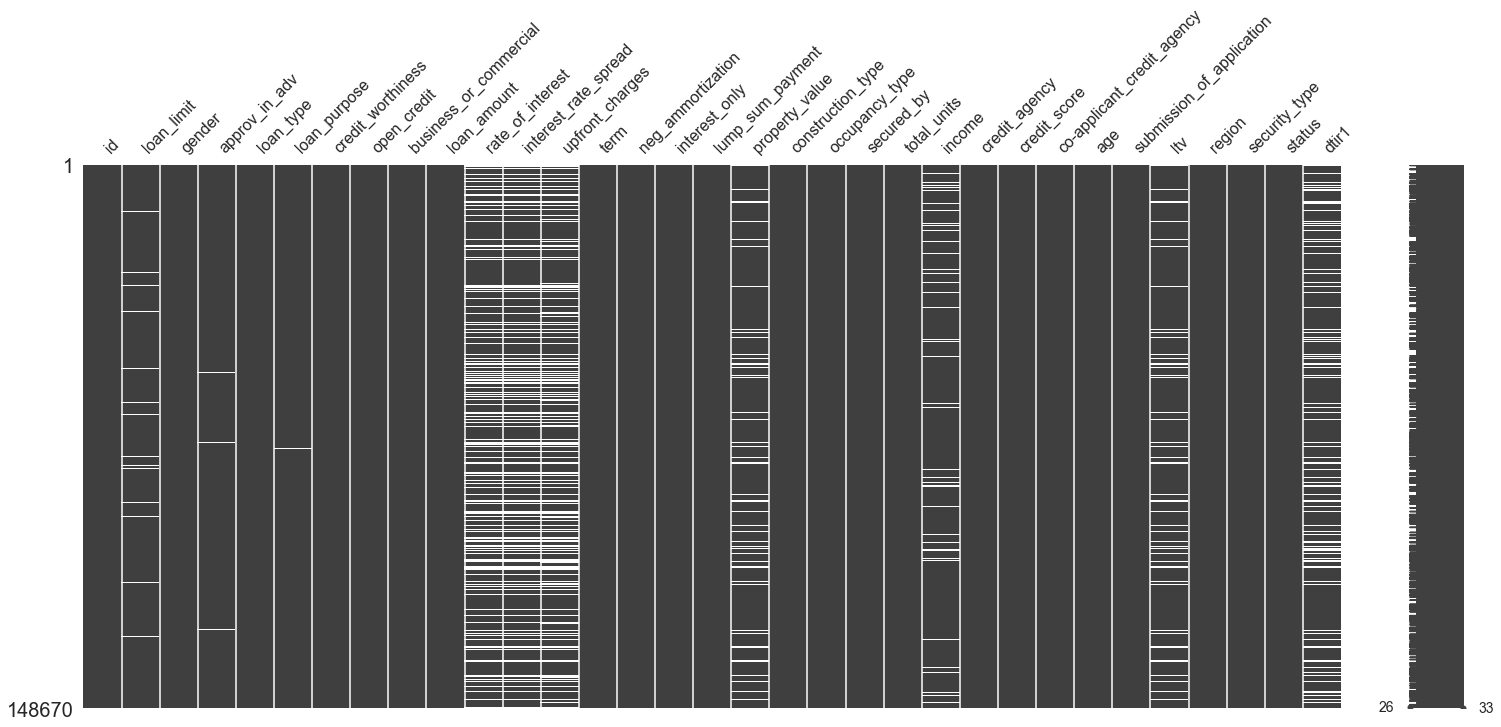

<Figure size 1080x504 with 0 Axes>

In [245]:
# Visuallize missing data
msno.matrix(data)
plt.figure(figsize = (15,7))
plt.show()

Using a heatmap to view *nullity correlation* of missing values. 
 
Correlation ranges from(-1 to 1):
- -1 means if one column(attribute) is present, the other is almost certainly absent.
- 0 means there is no dependence between the columns(attributes).
- 1 means if one column(attributes) is present, the other is also certainly present.

<AxesSubplot:>

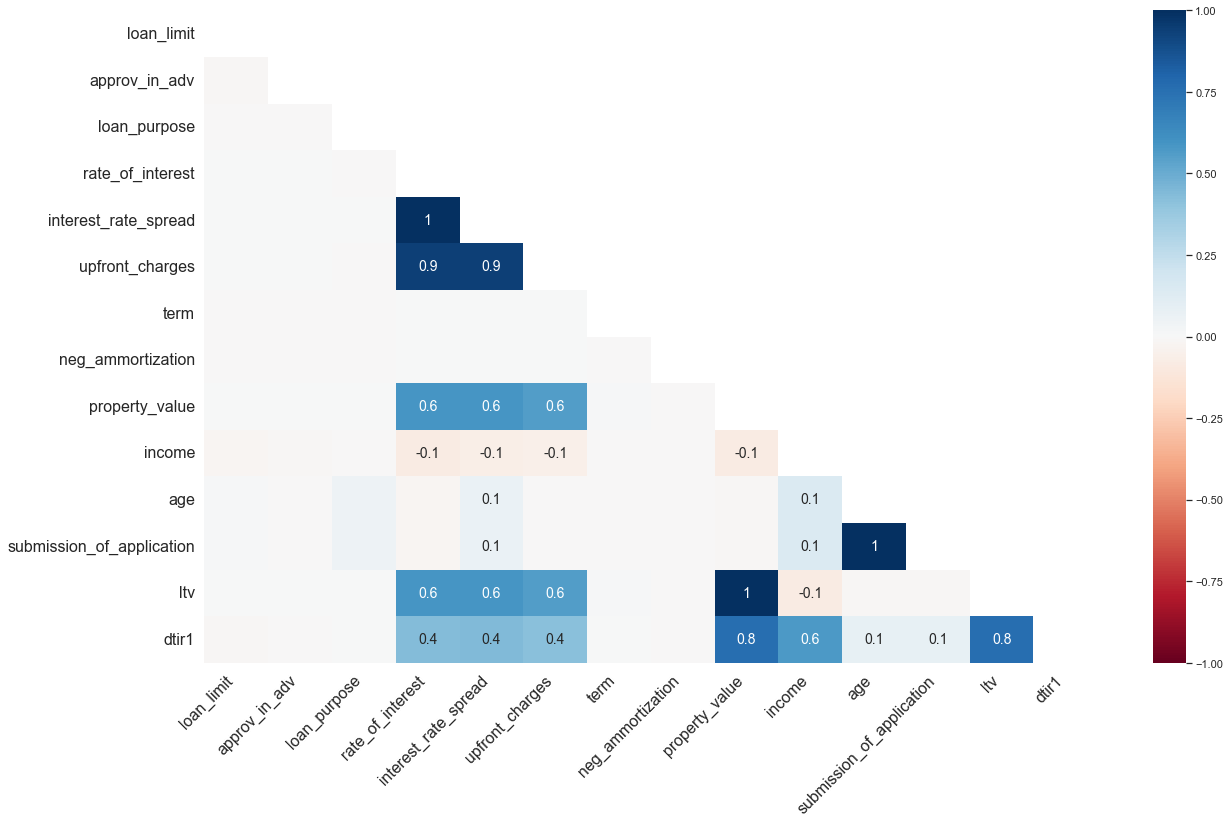

In [246]:
msno.heatmap(data, labels = True) #, figsize = (12, 6))

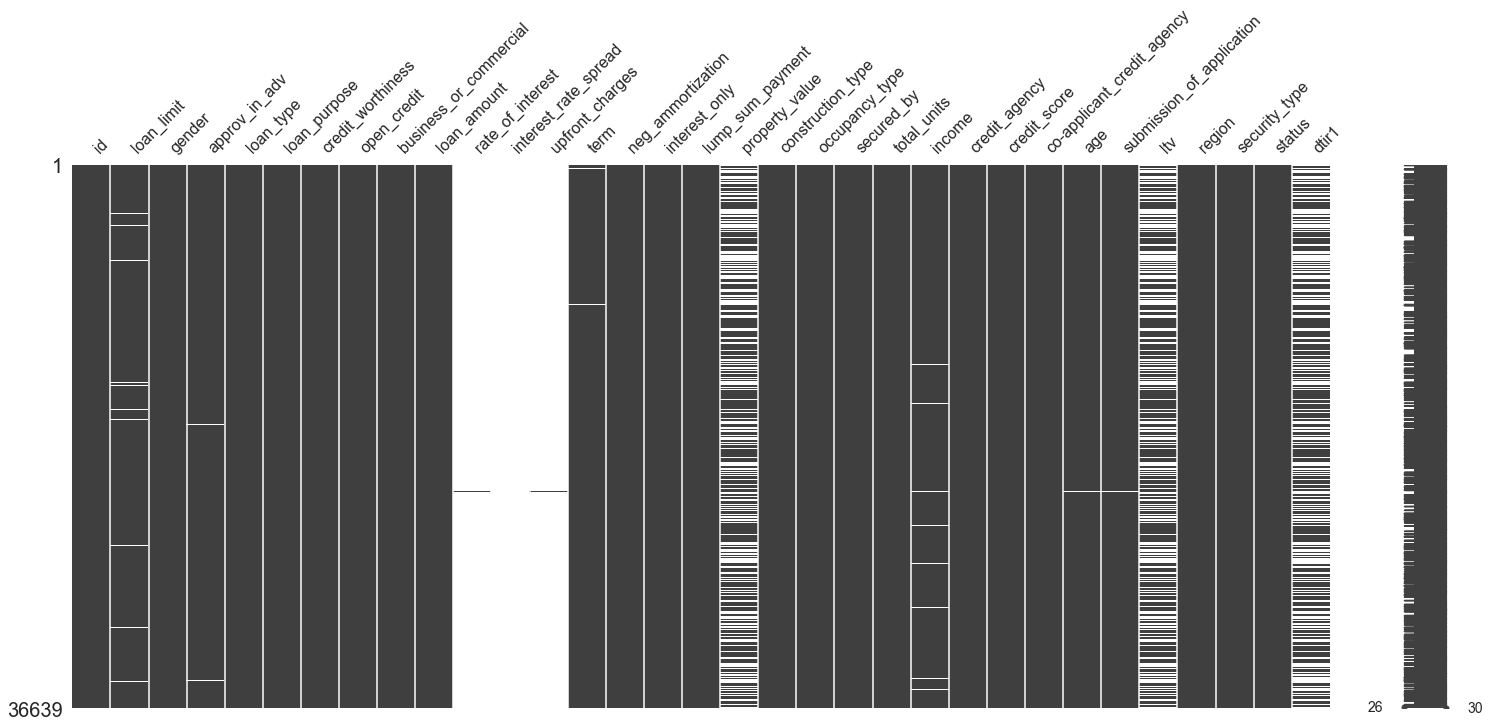

<Figure size 1080x504 with 0 Axes>

In [247]:
df_defaulted = data[data['status'] == 1]
#df_defaulted.iloc[:, 22:]

# Visuallize missing data for defaulted loans
msno.matrix(df_defaulted)
plt.figure(figsize = (15,7))
plt.show()

Credit reporting agencies collect information on borrowers, below shows missing information by credit reporting agency. We can see that the agency with the most missing data on borrowers is Equifax

EXP


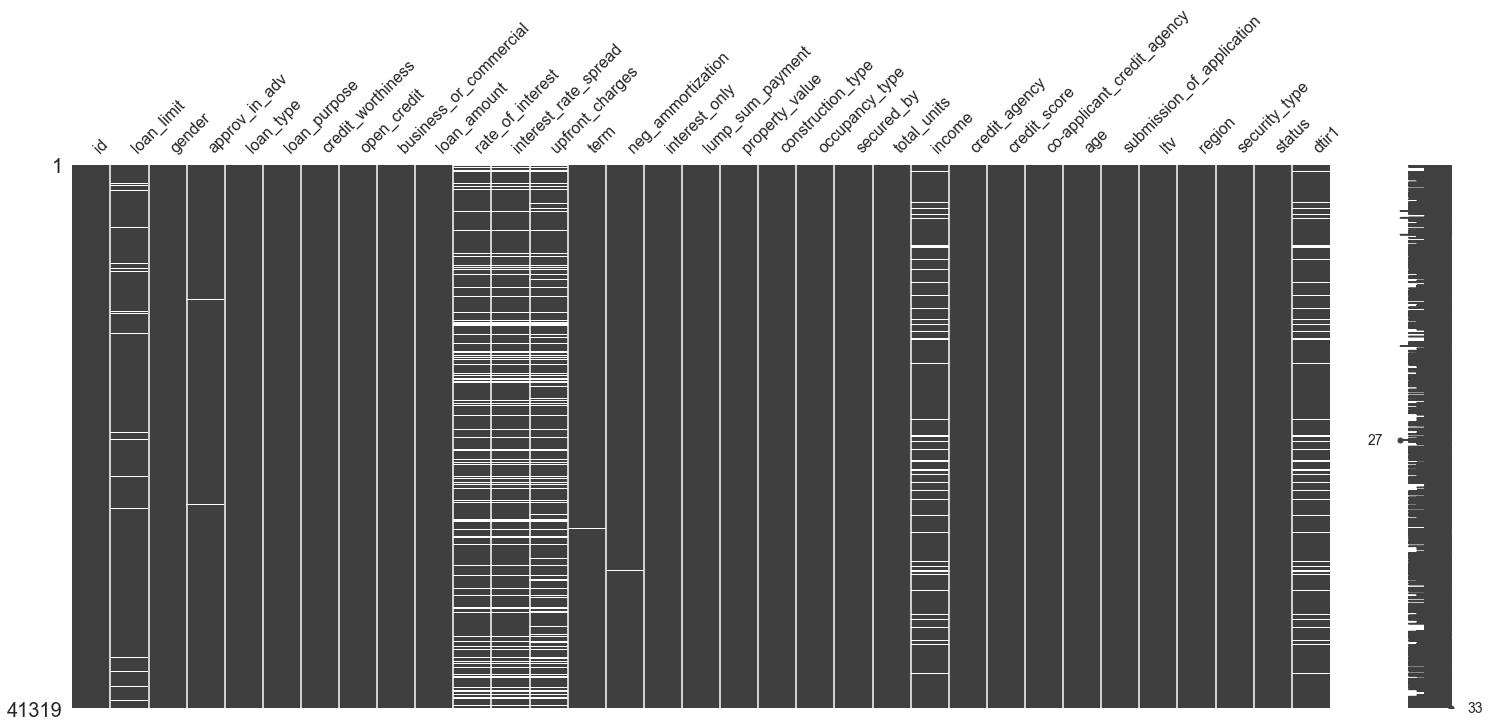

<Figure size 1080x504 with 0 Axes>

EQUI


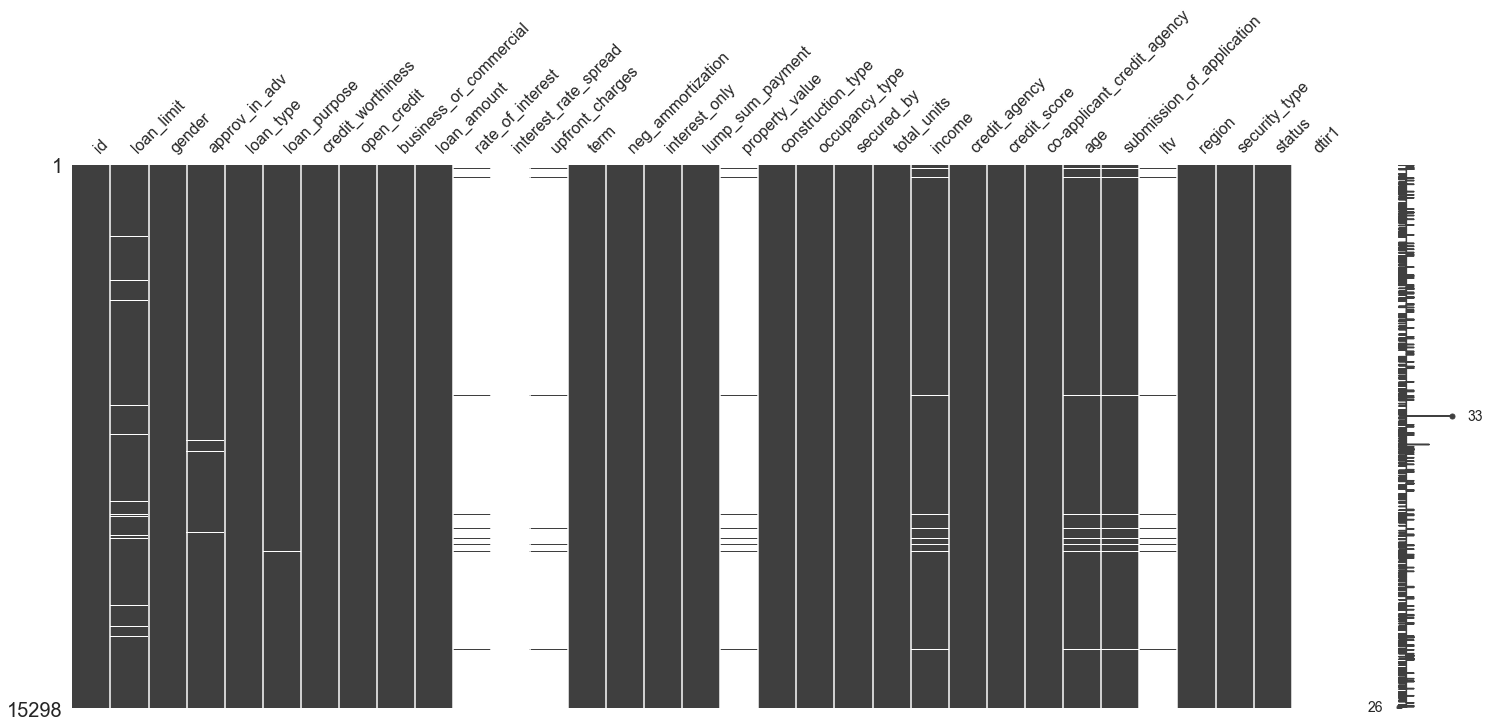

<Figure size 1080x504 with 0 Axes>

CRIF


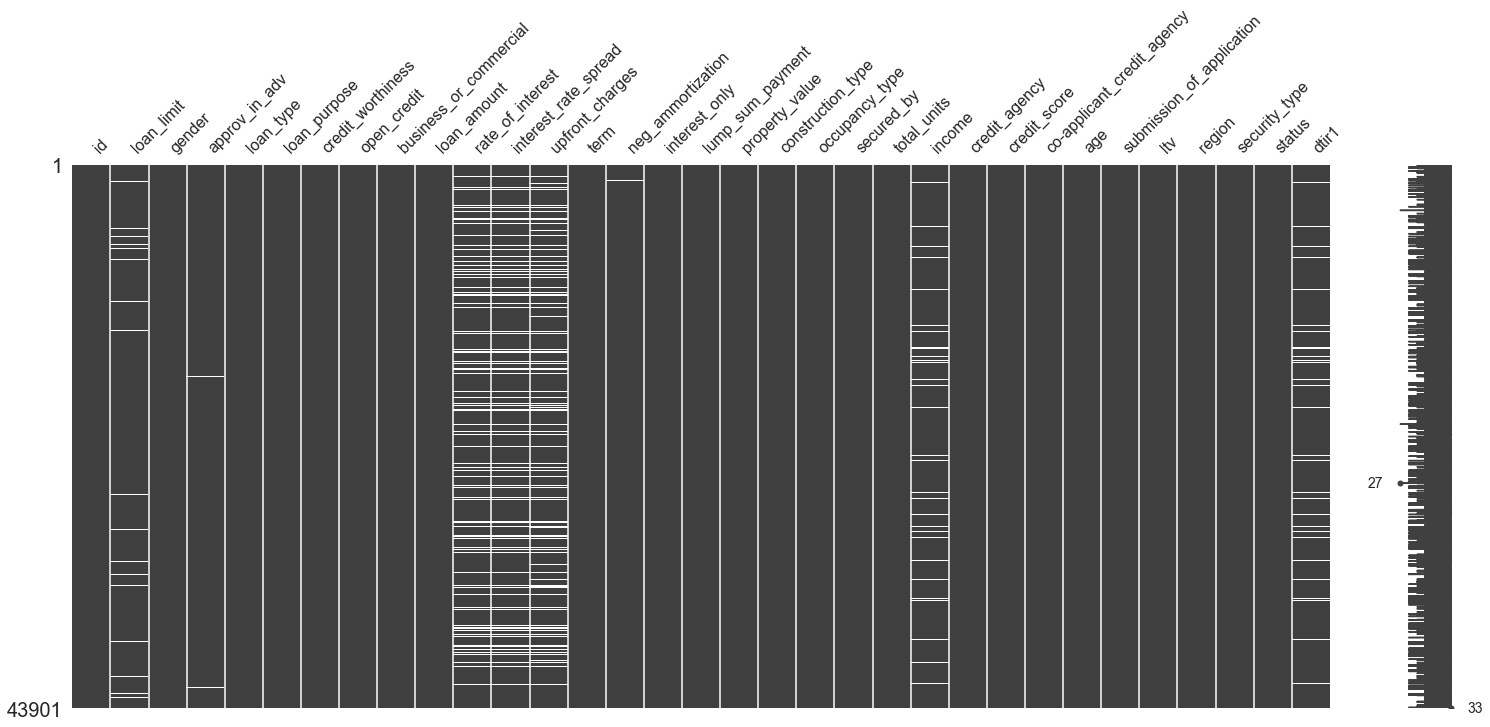

<Figure size 1080x504 with 0 Axes>

CIB


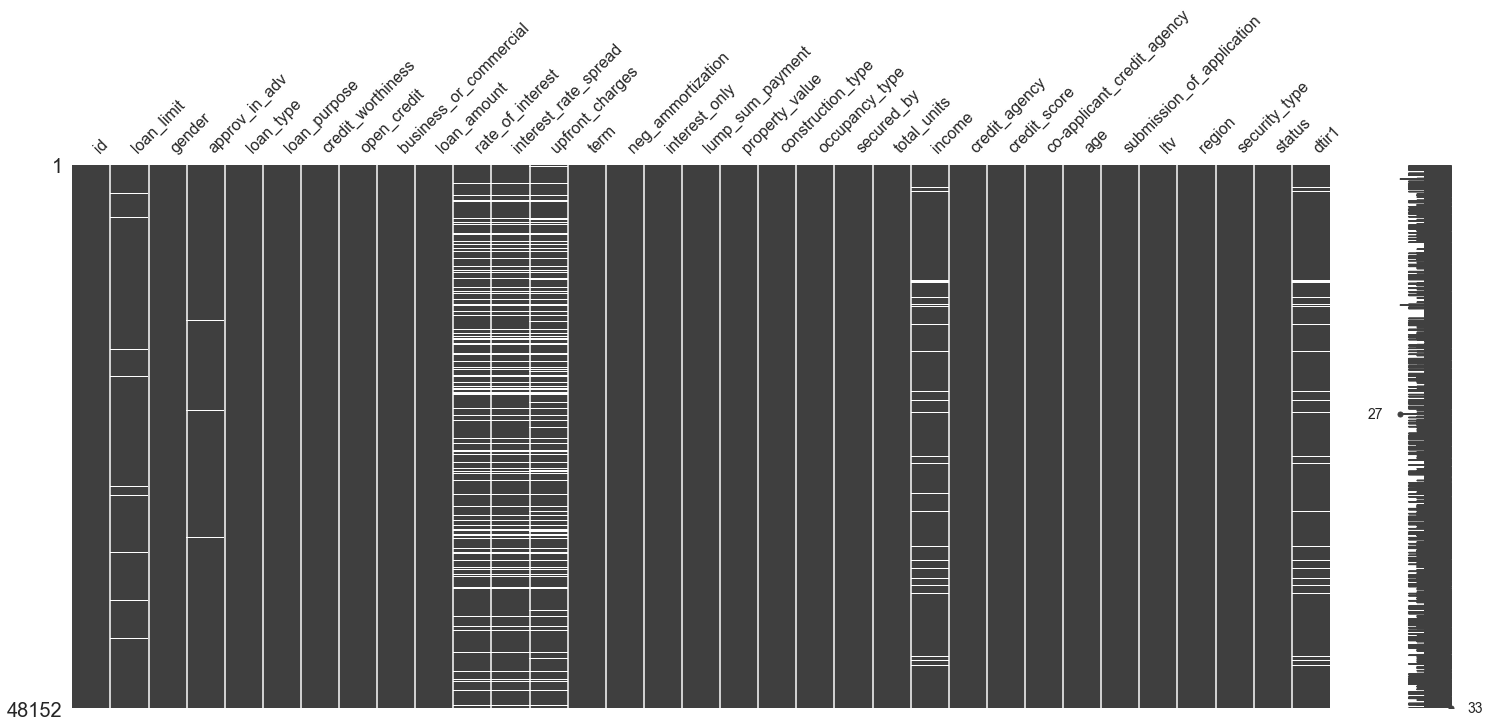

<Figure size 1080x504 with 0 Axes>

In [248]:
for i in data['credit_agency'].unique():
    print(str(i))
    msno.matrix(data[data['credit_agency'] == i])
    plt.figure(figsize = (15,7))
    plt.show()

<AxesSubplot:xlabel='credit_agency'>

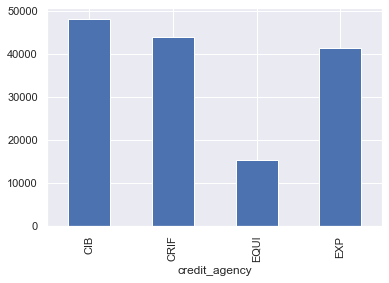

In [250]:
(data.groupby('credit_agency').size()).plot.bar(legend=False)

The field `co-applicant_credit_agency` corresponds to the credit agency that provided information on the co-applicant of the loan. Here we see that only two of the agencies are associated with the co-applicants: CIB and EXP. 

CIB


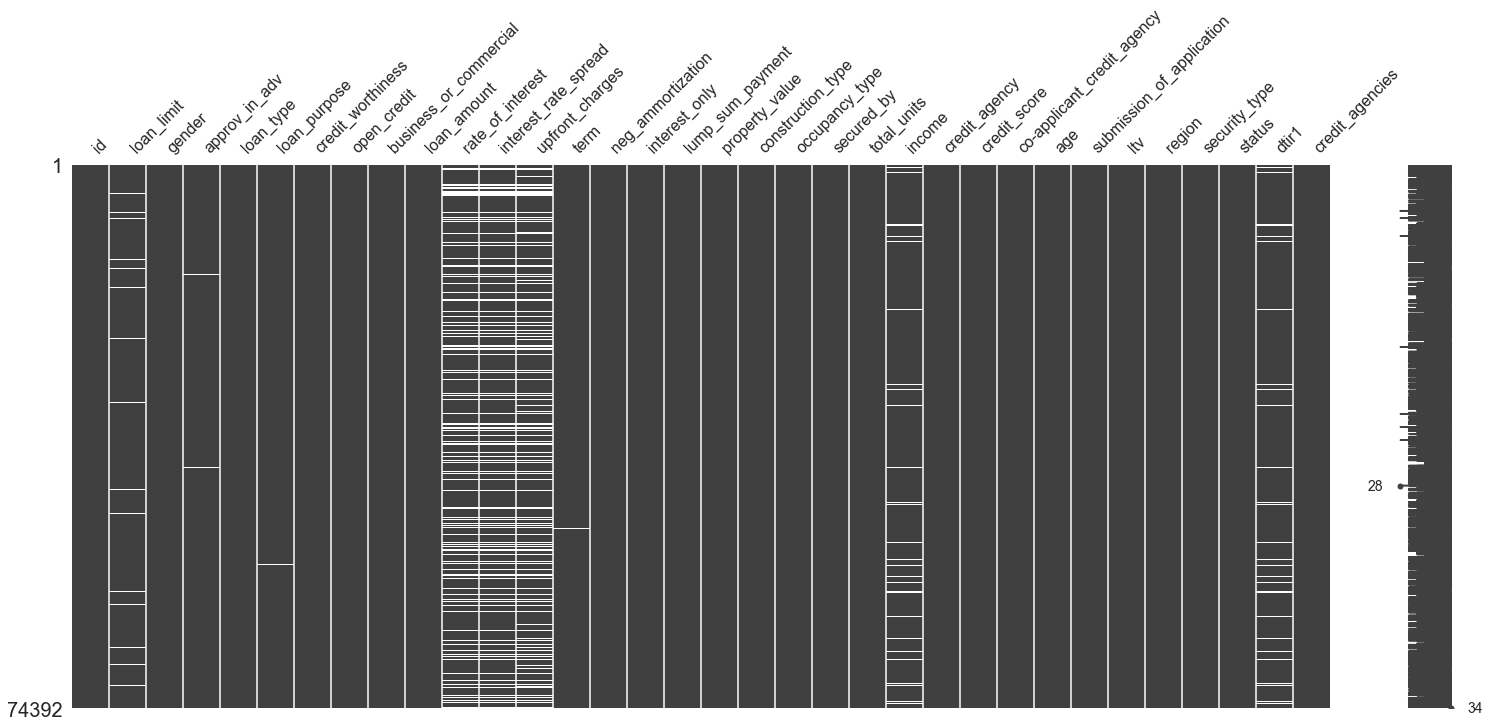

<Figure size 1080x504 with 0 Axes>

EXP


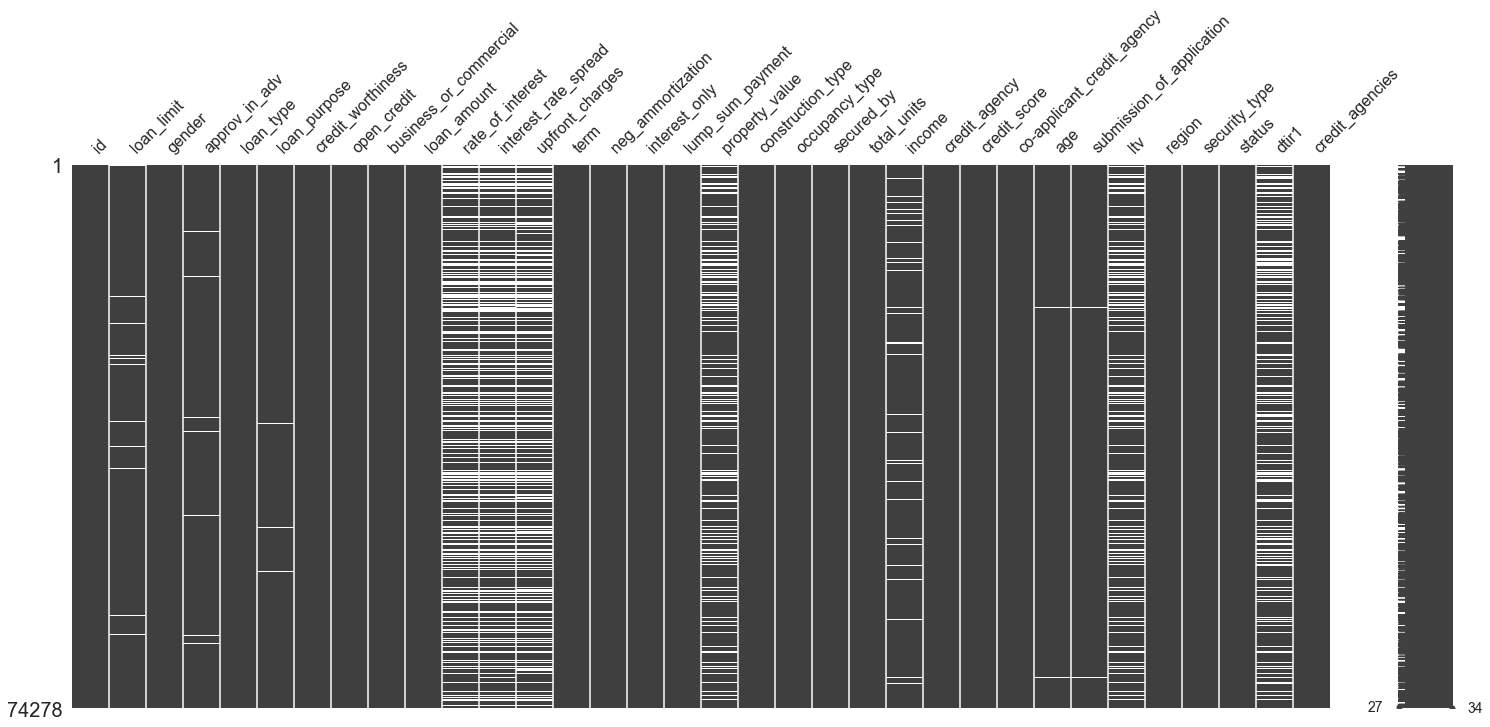

<Figure size 1080x504 with 0 Axes>

In [251]:
for i in data['co-applicant_credit_agency'].unique():
    print(str(i))
    msno.matrix(data[data['co-applicant_credit_agency'] == i])
    plt.figure(figsize = (15,7))
    plt.show()

From the charts above, it appears that missing data originates from the primary credit agency, not the secondary agency providing information on the co-applicant. Below we create a new a new field that combines the primary and secondary credit agencies to create new groups of credit agencies. This could help identify if there is a potential communication issue between agencies (different or incompatible data/reporting systems, for example). <br>

Based on the information in the charts below, we can conclude that **Equifax provides the most incomplete information** on borrowers regardless of who the secondary agency is.

In [252]:
data['credit_agencies'] = data['credit_agency'] + data['co-applicant_credit_agency']
data['credit_agencies'].unique()

array(['EXPCIB', 'EQUIEXP', 'CRIFEXP', 'EXPEXP', 'CIBCIB', 'CIBEXP',
       'CRIFCIB', 'EQUICIB'], dtype=object)

EXPCIB


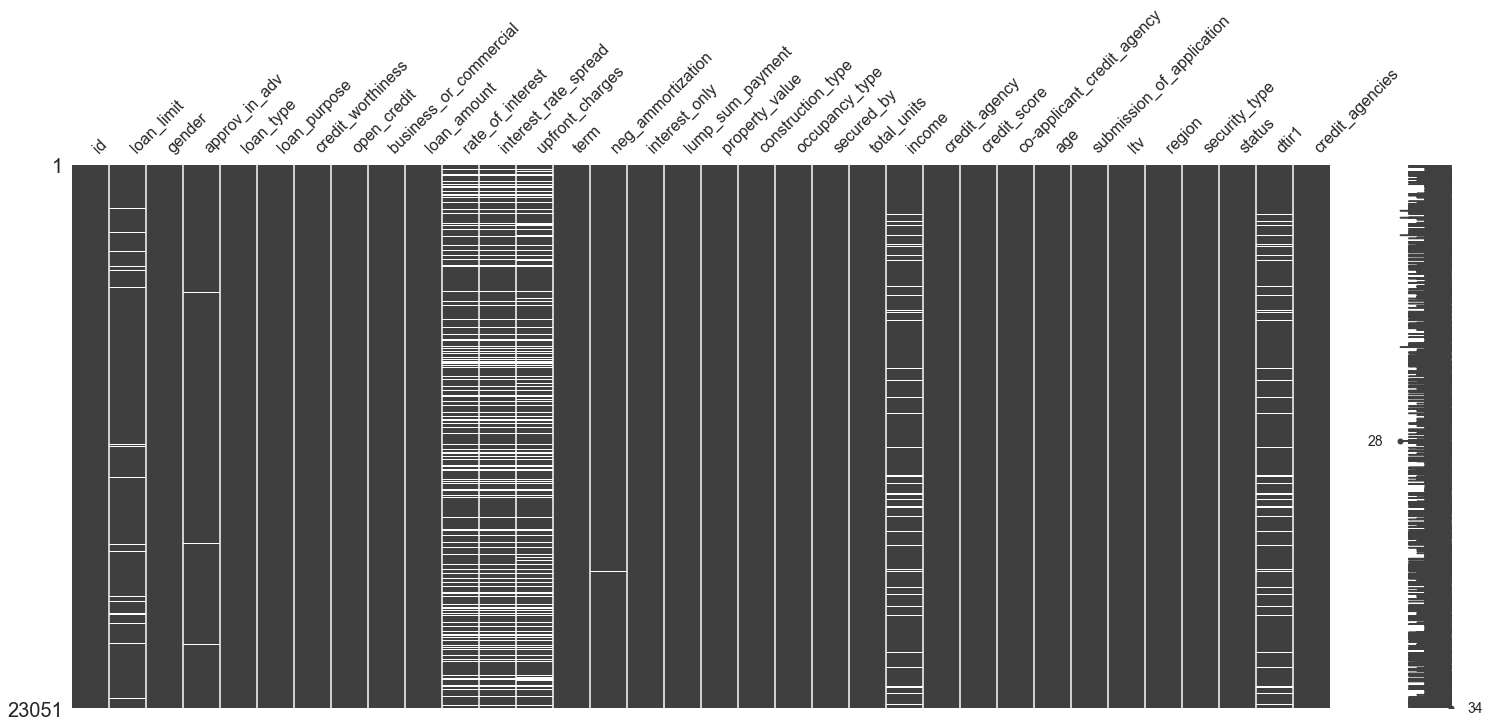

<Figure size 1080x360 with 0 Axes>

EQUIEXP


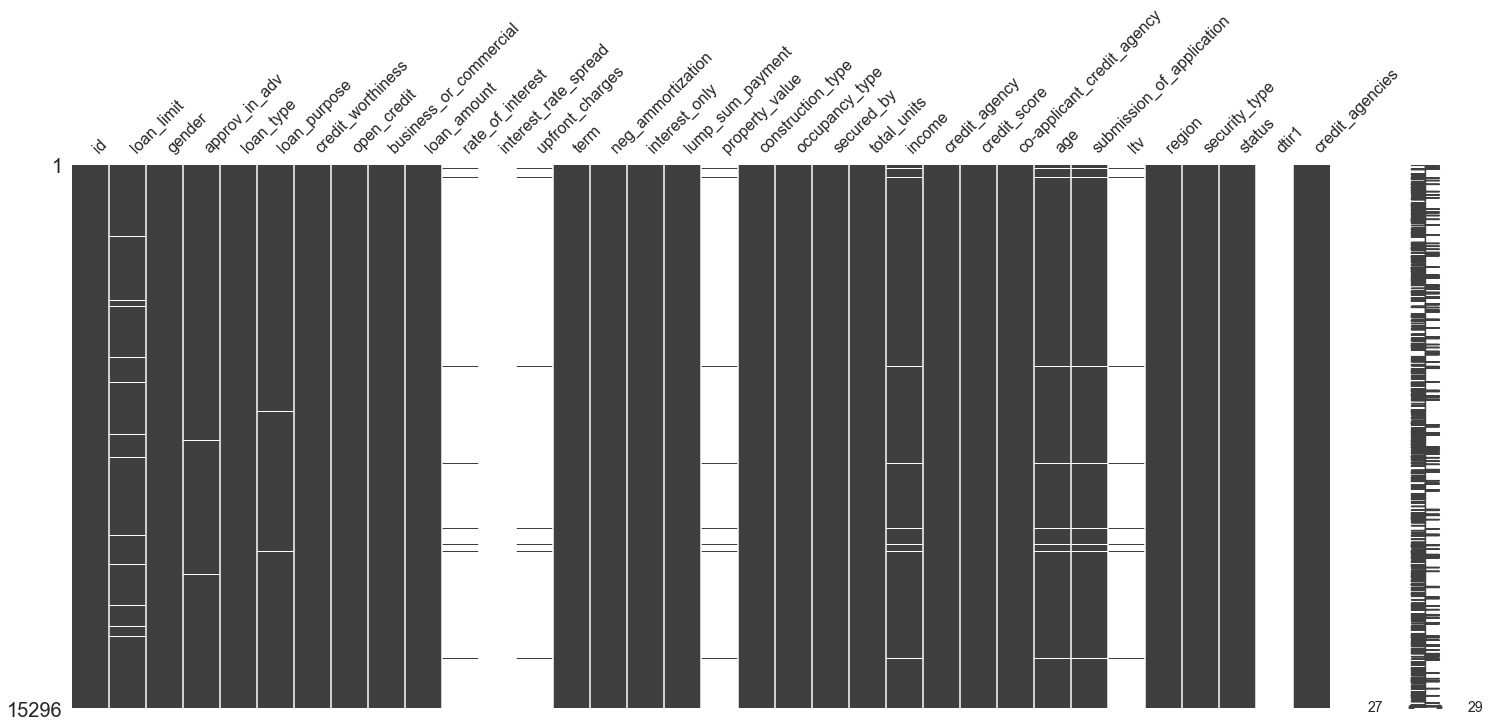

<Figure size 1080x360 with 0 Axes>

CRIFEXP


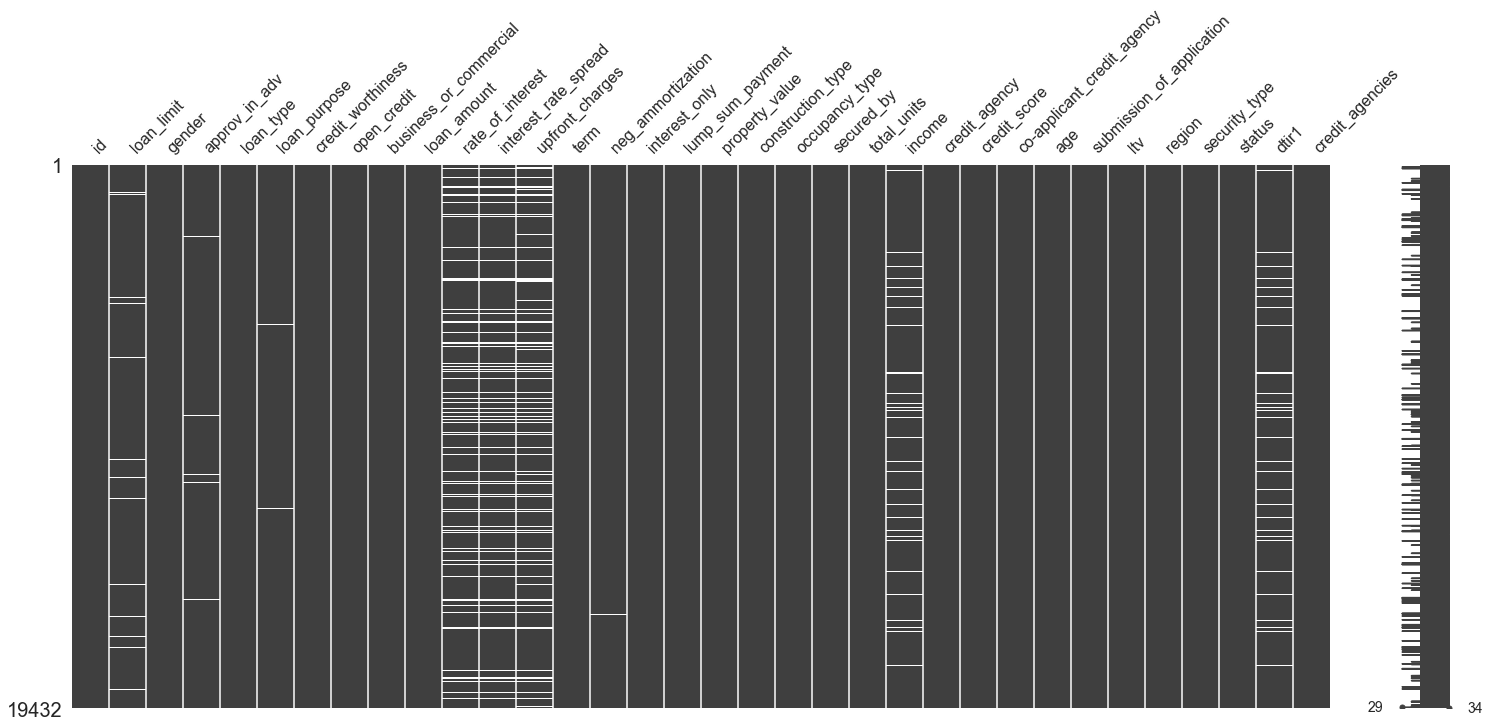

<Figure size 1080x360 with 0 Axes>

EXPEXP


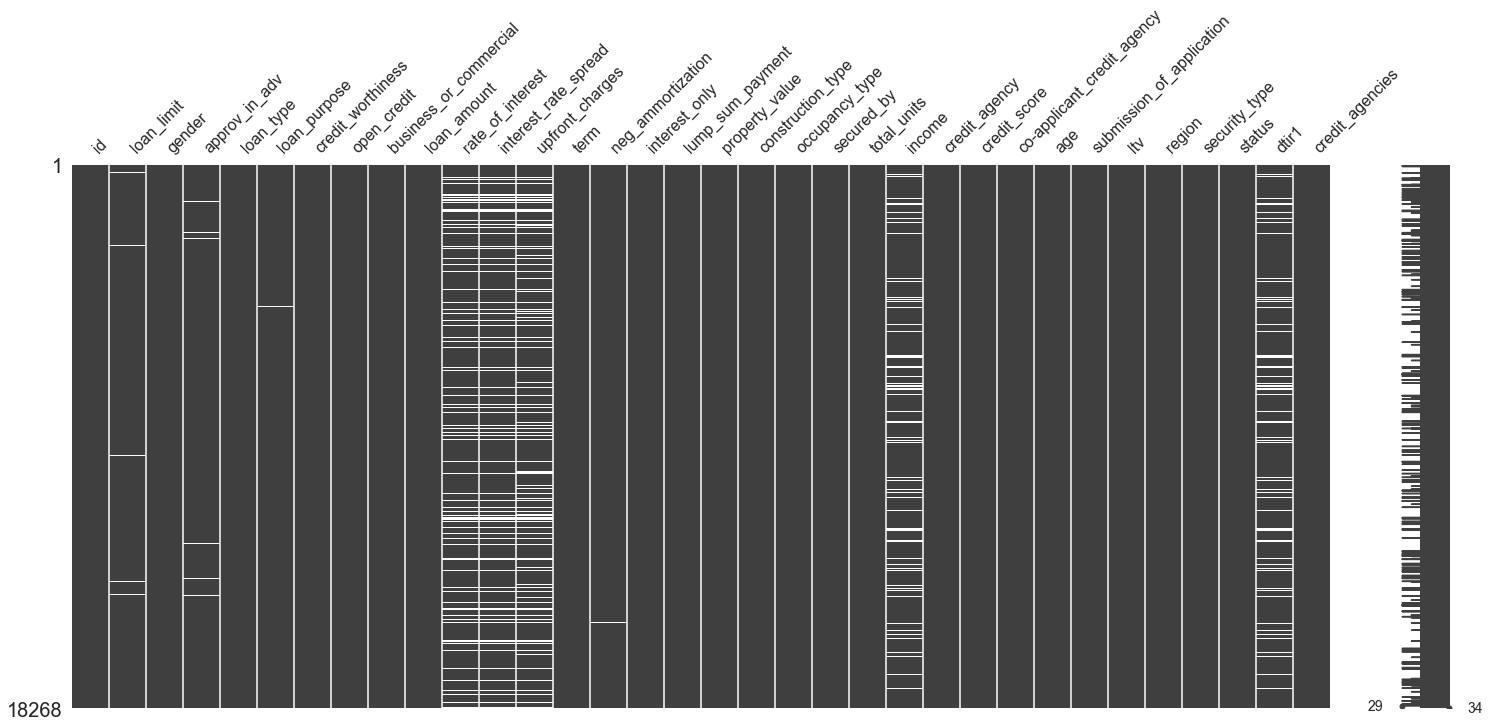

<Figure size 1080x360 with 0 Axes>

CIBCIB


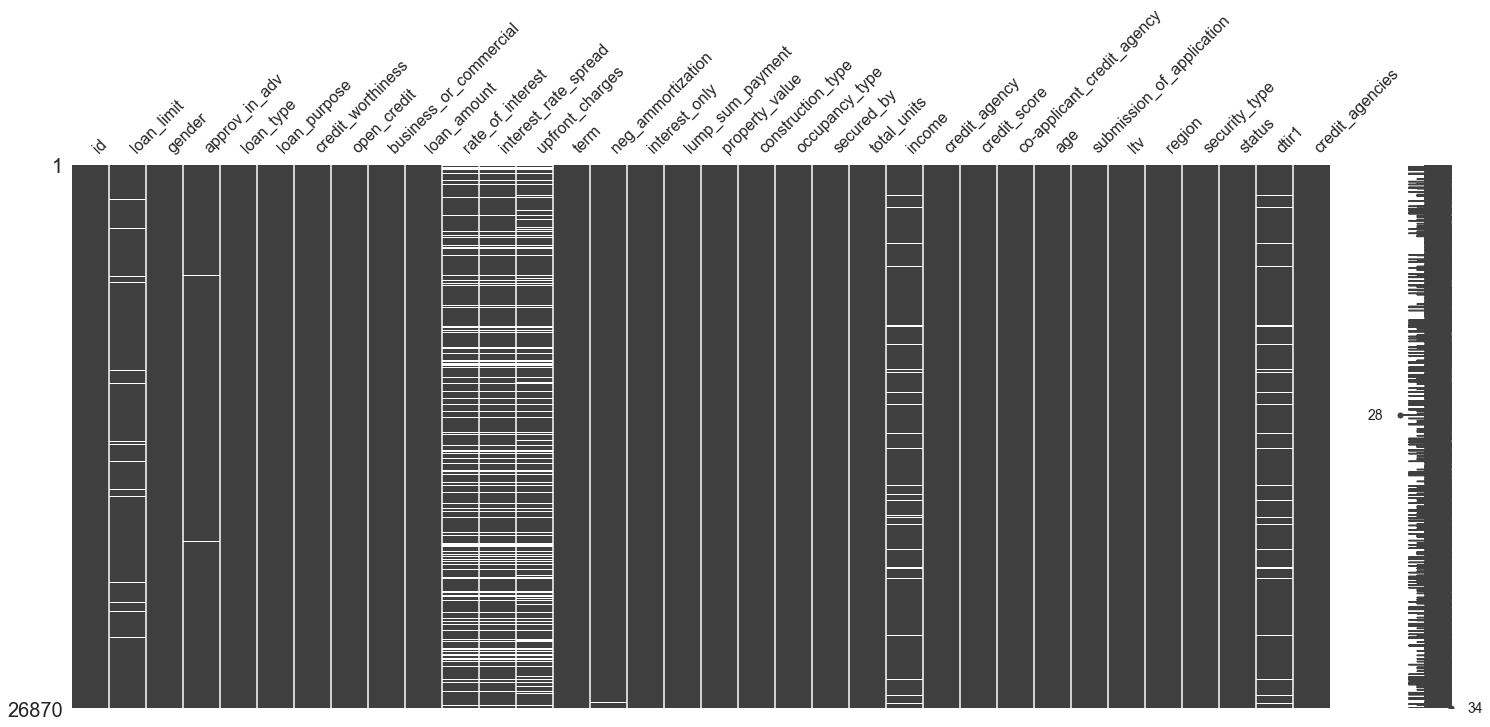

<Figure size 1080x360 with 0 Axes>

CIBEXP


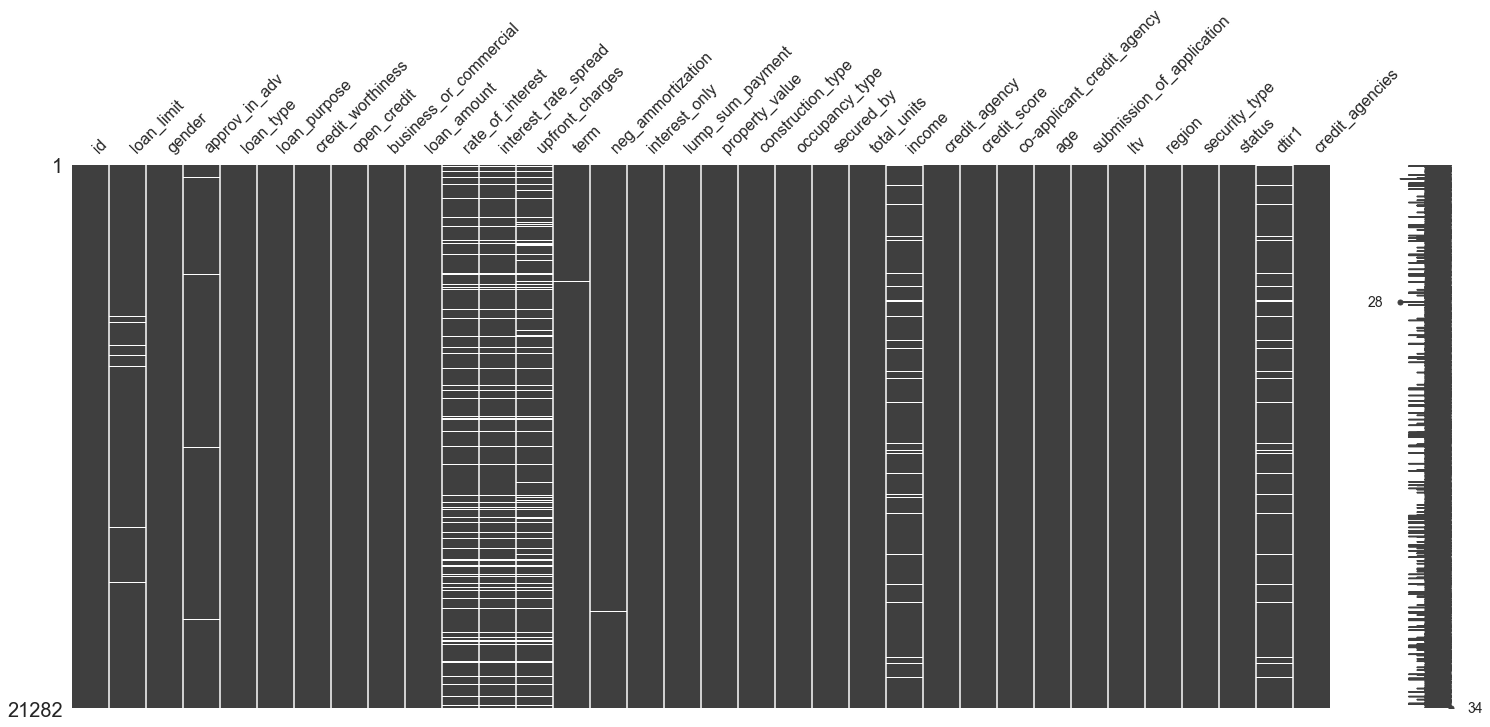

<Figure size 1080x360 with 0 Axes>

CRIFCIB


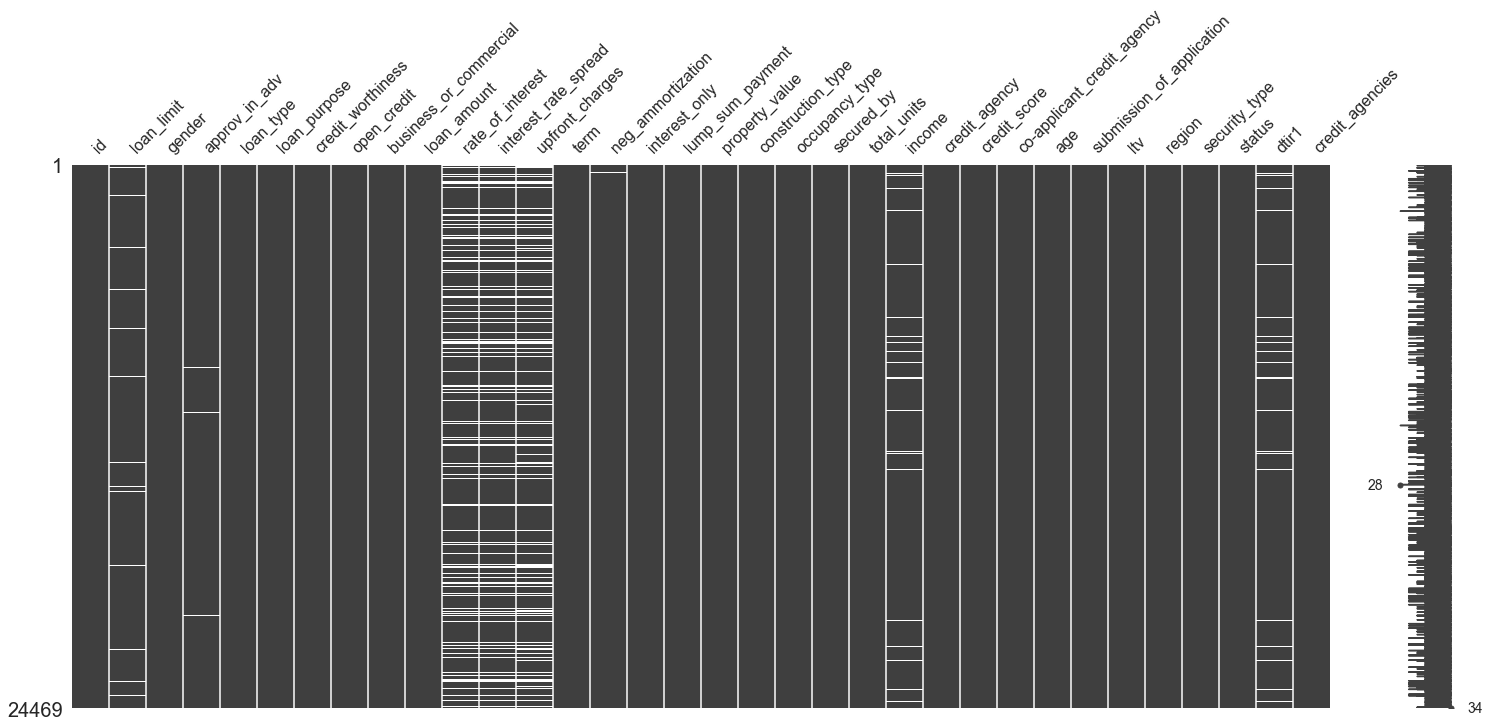

<Figure size 1080x360 with 0 Axes>

EQUICIB


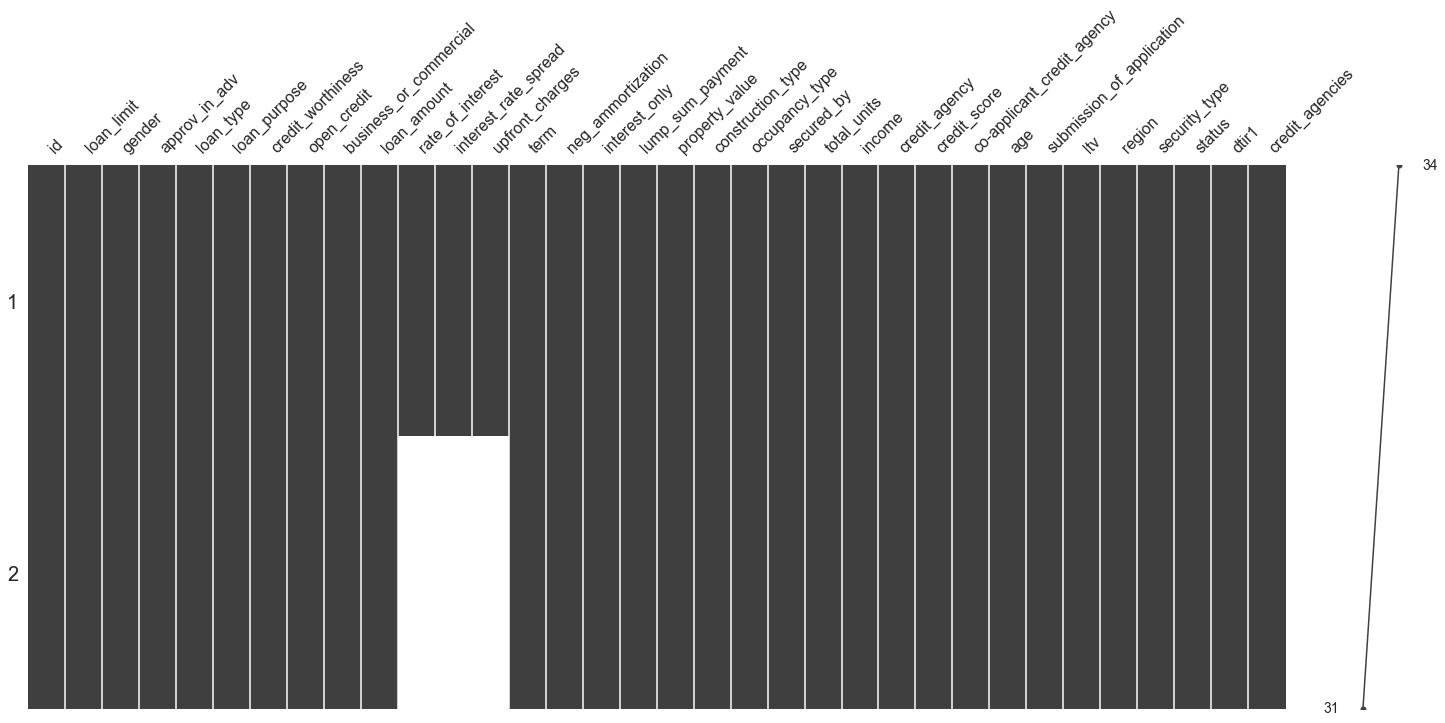

<Figure size 1080x360 with 0 Axes>

In [253]:
for i in data['credit_agencies'].unique():
    print(str(i))
    msno.matrix(data[data['credit_agencies'] == i])
    plt.figure(figsize = (15,5))
    plt.show()

Update the `object_cols` list once again since I've added a new column 

In [254]:
# Update object_cols list since I've renamed a couple columns
object_cols = list((data.select_dtypes('object').columns))
print(object_cols, '\n')

['loan_limit', 'gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'credit_worthiness', 'open_credit', 'business_or_commercial', 'neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'secured_by', 'total_units', 'credit_agency', 'co-applicant_credit_agency', 'age', 'submission_of_application', 'region', 'security_type', 'credit_agencies'] 



#### Will come back to deal with missing data

## Data Exploration:
---

#### Notes: <br>
- LTV = (loan_amount/property_value)*100 --> LTV is loan-to-value but LTV is multiplied by 100 in the dataset
- ditr1 is debt-to-income ratio. This typically respresnts the portion of the borrower's monthly income that goes towards paying thier debt. I wonder if income is a monthly income number then...

In [255]:
data.describe()

,id,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,property_value,income,credit_score,ltv,status,dtir1
count,148670.00,148670.00,112231.00,112031.00,109028.00,148629.00,133572.00,139520.00,148670.00,133572.00,148670.00,124549.00
mean,99224.50,331117.74,4.05,0.44,3225.00,335.14,497893.47,6957.34,699.79,72.75,0.25,37.73
std,42917.48,183909.31,0.56,0.51,3251.12,58.41,359935.32,6496.59,115.88,39.97,0.43,10.55
min,24890.00,16500.00,0.00,-3.64,0.00,96.00,8000.00,0.00,500.00,0.97,0.00,5.00
25%,62057.25,196500.00,3.62,0.08,581.49,360.00,268000.00,3720.00,599.00,60.47,0.00,31.00
50%,99224.50,296500.00,3.99,0.39,2596.45,360.00,418000.00,5760.00,699.00,75.14,0.00,39.00
75%,136391.75,436500.00,4.38,0.78,4812.50,360.00,628000.00,8520.00,800.00,86.18,0.00,45.00
max,173559.00,3576500.00,8.00,3.36,60000.00,360.00,16508000.00,578580.00,900.00,7831.25,1.00,61.00


#### What is LTV? <br>
I suspect it is loan-to-value...but let's see:

In [256]:
# First, what is LTV? I suspect it is loan-to-value
ltv_calc = (data['loan_amount']/data['property_value'])
ltv_calc.head(10)
data['ltv'].head(10)
ltv_calc*100

data['ltv'] - (ltv_calc*100)
# LTV is multipled by 100 in the dataset, but it does in fact repesent the loan-to-value
# LTV = (loan_amount/property_value)*100

0         0.00
1          NaN
2         0.00
3         0.00
4         0.00
          ... 
148665    0.00
148666   -0.00
148667   -0.00
148668    0.00
148669    0.00
Length: 148670, dtype: float64

#### Yes, LTV is loan-to-value. In the dataset, LTV is multipled by 100. <br>

$$ LTV = (loan amount / property value)*100 $$

#### What is dtir1? <br>
I suspect it is the debt-to-income ratio. However I'm not sure whether by "debt" that means the total debt the borrower inclusive of loans from other institutions or just the debt associated with this particular loan the individual has. Also, debt-to-income is typically measured in terms of monthly income. 

In [257]:
data[['loan_amount', 'term', 'income', 'dtir1']].head(10)

,loan_amount,term,income,dtir1
0,116500,360.00,1740.00,45.00
1,206500,360.00,4980.00,NaN
2,406500,360.00,9480.00,46.00
3,456500,360.00,11880.00,42.00
4,696500,360.00,10440.00,39.00
5,706500,360.00,10080.00,40.00
6,346500,360.00,5040.00,44.00
7,266500,360.00,3780.00,42.00
8,376500,360.00,5580.00,44.00
9,436500,360.00,6720.00,30.00


In [258]:
# ----------------------------------------------
# Trying different ways of calculating the dtir to see if I can match the dtir1 from the dataset:
# ----------------------------------------------

dtir_calc = ((data['loan_amount'])/data['income']) ## ------> NO
dtir_calc 

# Using loan amount divided by it's term (a VERY rough approximation for the monthly pmt) and income (assuming income is monthly)
dtir_calc = (data['loan_amount']/data['term'])/data['income'] ## -----> NO
dtir_calc 

# # Maybe income is not monthly, try multiplying income by 12...
dtir_calc = data['loan_amount']/(data['income']*12) ## -------> ALSO NO
dtir_calc 

# # Maybe debt (the numerator) is monthly, try multiplying debt by 12...
dtir_calc = (data['loan_amount']*12)/(data['income']) ## -------> ALSO NO...
dtir_calc 

0        803.45
1        497.59
2        514.56
3        461.11
4        800.57
          ...  
148665   666.41
148666   985.71
148667   776.52
148668   330.25
148669   671.90
Length: 148670, dtype: float64

I'm not certain how the DTIR is calculated in this dataset. I suspect it is inclusive of the borrower's debt from other loans and/or institutions, for now I assume that it is.  Another assumption I'm going to make is that the DTIR1 measure is multplied by 100 just like the LTV measure. <br>

**Because we can, let's reverse engineer the DTIR1 measure to see how much debt these borrowers are in....**

Let: <br>
- L = loan amount
- V = property value
- D = Debt amount (unclear whether this is total debt of the borrower or just debt to this loan)
- I = income of the borrower 

</br>

Then we have the following constructions: <br>
- Loan-to-value (LTV) = L/V
- Debt-to-Income Ratio (DTIR) = D/I

</br>

So now do simple algebra to solve for total debt: <br>
- **D = DTIR / I**


In [153]:
# COME BACK TO THIS NEED TO SUBSET FOR WHERE BOTH DTIR1 AND INCOME ARE NOT MISSING
# Given that we know the debt-to-income ratio and the income of the borrower, let's see how much debt they are in...
#borrower_total_debt = (data[data['dtir1'].notnull()]['dtir1']/100)*data[data['dtir1'].notnull()]['income']
#borrower_total_debt 

In [154]:
#borrower_total_debt.describe()

In [155]:
#np.quantile(borrower_total_debt, q = .75)

In [156]:
#plt.hist(borrower_total_debt)

In [157]:
#df_raw.query('rate_of_interest == 0').shape[0]

1

<font color = 'red'> REMOVE THIS SECTION?: Check out the skew on the features: </font>

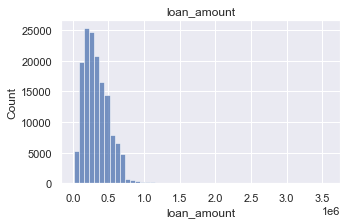

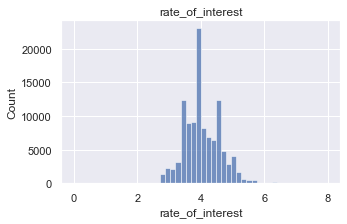

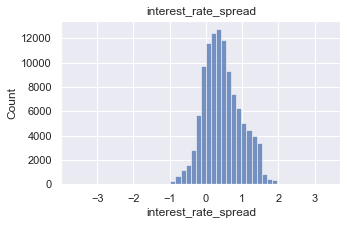

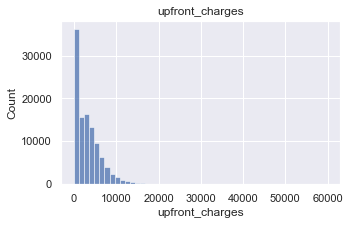

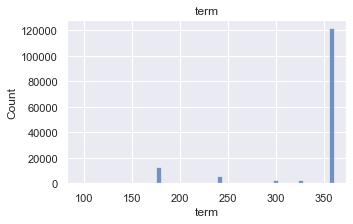

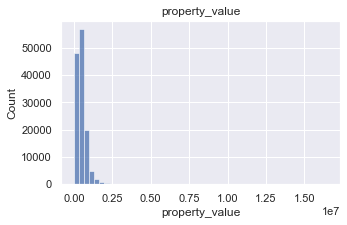

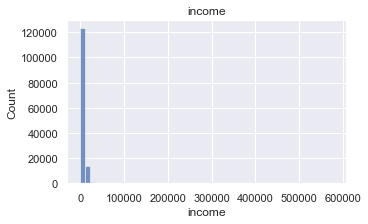

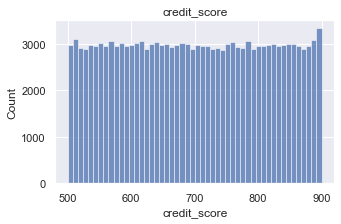

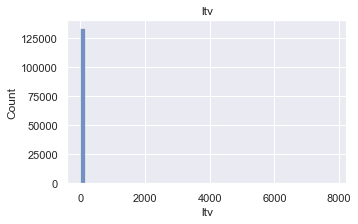

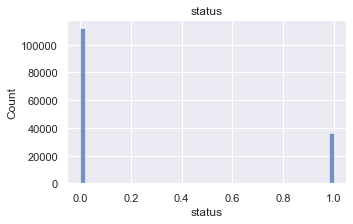

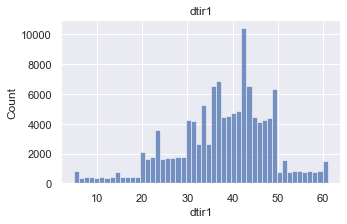

In [259]:
for col_i in numeric_cols:
    plt.figure(figsize = (5,3)) # need this for each plot to be rendered, otherwise shows only last plot
    #px.histogram(data, x = col_i, nbins = 50)
    sns.histplot(data = data, x = col_i, bins = 50)
    plt.title(col_i)
    plt.xlabel(col_i)
    plt.show()

In [159]:
data.describe()

,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,property_value,income,credit_score,ltv,status,dtir1
count,148670.00,112231.00,112031.00,109028.00,148629.00,133572.00,139520.00,148670.00,133572.00,148670.00,124549.00
mean,331117.74,4.05,0.44,3225.00,335.14,497893.47,6957.34,699.79,72.75,0.25,37.73
std,183909.31,0.56,0.51,3251.12,58.41,359935.32,6496.59,115.88,39.97,0.43,10.55
min,16500.00,0.00,-3.64,0.00,96.00,8000.00,0.00,500.00,0.97,0.00,5.00
25%,196500.00,3.62,0.08,581.49,360.00,268000.00,3720.00,599.00,60.47,0.00,31.00
50%,296500.00,3.99,0.39,2596.45,360.00,418000.00,5760.00,699.00,75.14,0.00,39.00
75%,436500.00,4.38,0.78,4812.50,360.00,628000.00,8520.00,800.00,86.18,0.00,45.00
max,3576500.00,8.00,3.36,60000.00,360.00,16508000.00,578580.00,900.00,7831.25,1.00,61.00


Notice above that the minimum interest rate spread < 0, so a negative interest rate spread...interesting...

In [261]:
# Check numeric columns with a min of 0
for col_i in numeric_cols:
    if data[col_i].min() <= 0:
        print(col_i)

rate_of_interest
interest_rate_spread
upfront_charges
income
status


In [262]:
data[numeric_cols].isna().sum()

loan_amount                 0
rate_of_interest        36439
interest_rate_spread    36639
upfront_charges         39642
term                       41
property_value          15098
income                   9150
credit_score                0
ltv                     15098
status                      0
dtir1                   24121
dtype: int64

## Handling missing data:
___

#### What happens if we want to drop some missing data...

Let's check how much of our data still contains default records (status = 1) if I drop all NaN values...

In [263]:
df_temp = data.dropna().copy()
print("% data loss if remove all rows with NaN: " + str(1-(df_temp.shape[0]/data.shape[0])))

% data loss if remove all rows with NaN: 0.33956413533328844


Come back and decide how to handle missing data...Will lose ~34% of data if delete all NaNs

In [264]:
df_temp[df_temp['status'] == 1]

,id,loan_limit,gender,approv_in_adv,loan_type,loan_purpose,credit_worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,secured_by,total_units,income,credit_agency,credit_score,co-applicant_credit_agency,age,submission_of_application,ltv,region,security_type,status,dtir1,credit_agencies


Well we can't drop all NaN records because that will leave us with zero true labels...will have to use **imputation** to fill this missing values

In [163]:
# not_missing_cols = [col for col in data.columns if data[col].notnull().sum() > 0]
# not_missing_cols 

### Handling missing data in numerical columns: Imputation

In the first version of this notebook (1.1 - Loan Default EDA and Cleaning) I handled missing categorical data by treating missing values as it's own  naturally occuring category. This however had an adverse impact on feature selection later down the road (see notebook 2.1 - Loan Default Feature Exploration). <br>

**Here I will try a different imputation approach for categorical variables: using a bagged tree.**  This requires `sklearn.ensemble.BaggingRegressor` <br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html?highlight=baggingregress#sklearn.ensemble.BaggingRegressor <br>

Before I can apply this method, I must **first perform encoding of the categorical data**. As seen in notebook 2.1, nominal encoding is the most appropriate encoding method given the absence of a linear relationship between the variables and the response. 

In [265]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [165]:
#data = pd.read_csv(str(os.getcwd()) + '\\data_prepped_V1.csv')
# df_imputed = data.copy()
# df_imputed.describe()

,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,property_value,income,credit_score,ltv,status,dtir1
count,148670.00,112231.00,112031.00,109028.00,148629.00,133572.00,139520.00,148670.00,133572.00,148670.00,124549.00
mean,331117.74,4.05,0.44,3225.00,335.14,497893.47,6957.34,699.79,72.75,0.25,37.73
std,183909.31,0.56,0.51,3251.12,58.41,359935.32,6496.59,115.88,39.97,0.43,10.55
min,16500.00,0.00,-3.64,0.00,96.00,8000.00,0.00,500.00,0.97,0.00,5.00
25%,196500.00,3.62,0.08,581.49,360.00,268000.00,3720.00,599.00,60.47,0.00,31.00
50%,296500.00,3.99,0.39,2596.45,360.00,418000.00,5760.00,699.00,75.14,0.00,39.00
75%,436500.00,4.38,0.78,4812.50,360.00,628000.00,8520.00,800.00,86.18,0.00,45.00
max,3576500.00,8.00,3.36,60000.00,360.00,16508000.00,578580.00,900.00,7831.25,1.00,61.00


In [266]:
cat_missing_cols = [col for col in missing_cols if data[col].dtype == 'object']
cat_missing_cols

['loan_limit',
 'approv_in_adv',
 'loan_purpose',
 'neg_ammortization',
 'age',
 'submission_of_application']

**Encoding categorical features with `sklearn.preprocessing.LabelEncoder` (nominal encoding) for imputation purposes**

In [268]:
df_encode = data.copy()

In [269]:
[col for col in df_encode.columns if df_encode[col].isnull().sum() > 0]

['loan_limit',
 'approv_in_adv',
 'loan_purpose',
 'rate_of_interest',
 'interest_rate_spread',
 'upfront_charges',
 'term',
 'neg_ammortization',
 'property_value',
 'income',
 'age',
 'submission_of_application',
 'ltv',
 'dtir1']

In [270]:
# Get most updated list of categorical columns:
object_cols = list((data.select_dtypes('object').columns))
print(object_cols, '\n')

['loan_limit', 'gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'credit_worthiness', 'open_credit', 'business_or_commercial', 'neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'secured_by', 'total_units', 'credit_agency', 'co-applicant_credit_agency', 'age', 'submission_of_application', 'region', 'security_type', 'credit_agencies'] 



In [271]:
# use this to "un-encode" categorical variables after the imputation routine
encode_cols = object_cols 
encode_cols

['loan_limit',
 'gender',
 'approv_in_adv',
 'loan_type',
 'loan_purpose',
 'credit_worthiness',
 'open_credit',
 'business_or_commercial',
 'neg_ammortization',
 'interest_only',
 'lump_sum_payment',
 'construction_type',
 'occupancy_type',
 'secured_by',
 'total_units',
 'credit_agency',
 'co-applicant_credit_agency',
 'age',
 'submission_of_application',
 'region',
 'security_type',
 'credit_agencies']

In [305]:
missing_age_ids = data[data['age'].isnull()]['id']
#missing_age_ids
missing_rate_info_ids = data[data['rate_of_interest'].isnull()]['id']
#missing_rate_info_ids

0          24890
1          24891
10         24900
12         24902
15         24905
           ...  
148651    173541
148652    173542
148658    173548
148661    173551
148663    173553
Name: id, Length: 36439, dtype: int64

In [288]:
data[data['age'].isnull()] #['id']

,id,loan_limit,gender,approv_in_adv,loan_type,loan_purpose,credit_worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,secured_by,total_units,income,credit_agency,credit_score,co-applicant_credit_agency,age,submission_of_application,ltv,region,security_type,status,dtir1,credit_agencies
266,25156,ncf,Sex Not Available,nopre,type2,p1,l1,nopc,b/c,196500,3.75,NaN,0.00,324.00,neg_amm,not_int,not_lpsm,198000.00,sb,pr,home,1U,NaN,EQUI,768,EXP,NaN,NaN,99.24,south,direct,1,NaN,EQUIEXP
706,25596,ncf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,126500,4.62,NaN,3557.92,324.00,neg_amm,not_int,not_lpsm,168000.00,sb,pr,home,3U,NaN,EQUI,845,EXP,NaN,NaN,75.30,south,direct,1,NaN,EQUIEXP
1150,26040,ncf,Sex Not Available,nopre,type2,p3,l1,nopc,b/c,176500,3.75,NaN,0.00,324.00,neg_amm,not_int,not_lpsm,218000.00,sb,pr,home,1U,NaN,EQUI,572,EXP,NaN,NaN,80.96,south,direct,1,NaN,EQUIEXP
1219,26109,ncf,Sex Not Available,nopre,type2,p3,l1,nopc,b/c,346500,4.50,NaN,2062.49,324.00,neg_amm,not_int,not_lpsm,418000.00,sb,pr,home,1U,NaN,EQUI,864,EXP,NaN,NaN,82.89,south,direct,1,NaN,EQUIEXP
3533,28423,ncf,Sex Not Available,nopre,type2,p3,l1,nopc,b/c,146500,3.88,NaN,1128.66,324.00,neg_amm,not_int,not_lpsm,178000.00,sb,pr,home,1U,NaN,EQUI,540,EXP,NaN,NaN,82.30,south,direct,1,NaN,EQUIEXP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145071,169961,ncf,Sex Not Available,nopre,type2,p3,l1,nopc,b/c,156500,3.99,NaN,272.50,324.00,neg_amm,not_int,not_lpsm,188000.00,sb,pr,home,1U,NaN,EQUI,651,EXP,NaN,NaN,83.24,south,direct,1,NaN,EQUIEXP
147037,171927,ncf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,446500,4.88,NaN,7195.00,324.00,neg_amm,not_int,not_lpsm,608000.00,sb,pr,home,1U,NaN,EQUI,591,EXP,NaN,NaN,73.44,south,direct,1,NaN,EQUIEXP
147799,172689,ncf,Sex Not Available,nopre,type2,NaN,l1,nopc,b/c,206500,3.99,NaN,0.00,360.00,neg_amm,not_int,not_lpsm,228000.00,sb,pr,home,1U,NaN,EQUI,527,EXP,NaN,NaN,90.57,south,direct,1,NaN,EQUIEXP
147974,172864,ncf,Sex Not Available,nopre,type2,p4,l1,nopc,b/c,616500,3.75,NaN,7638.27,360.00,neg_amm,not_int,not_lpsm,668000.00,sb,pr,home,1U,NaN,EQUI,604,EXP,NaN,NaN,92.29,south,direct,1,NaN,EQUIEXP


7

In [277]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

for col in encode_cols:
    df_encode[col] = lb.fit_transform(df_encode[col])

In [335]:
#[col for col in df_encode.columns if df_encode[col].isnull().sum() > 0]

In [324]:
print("Number of age categories = " + str(len(data['age'].unique())-1))

Number of age categories = 7


In [333]:
# note that the label encoder assigned NaNs it's own category (value) - here it assigns missing age groups as group 7
print("The number assigned to missing age groups is: ")
(df_encode.loc[df_encode['id'].isin(missing_age_ids)])['age'].unique()[0]

The number assigned to missing age groups is: 


7

In [297]:
data[object_cols].isna().sum().sum()

4907

In [58]:
#dr = DecisionTreeRegressor()

Perform imputation on all columns with missing values (categorical columns have been assigned numerical values via encoding)

In [187]:
def tree_imputation(df):
    
    missing_cols = [col for col in df.columns if df[col].isnull().sum() > 0]
    non_missing_cols = [col for col in df.columns if df[col].isnull().sum() == 0]
    # num_cols = [col for col in missing_cols if df[col].dtype != 'object']

    # df = df[num_cols]
    for col in missing_cols:

        # Defining a new bagging model for each attribute  
        model = BaggingRegressor(DecisionTreeRegressor(), n_estimators = 40,
                                 max_samples = 1.0, max_features = 1.0, bootstrap = False, n_jobs = -1)    
        
        col_missing = df[df[col].isnull()]
        temp = df.drop(df[df[col].isnull()].index, axis = 0)

        X = temp.loc[:, non_missing_cols]
        y = temp[col]

        model.fit(X, y)
        
        y_pred = model.predict(col_missing[non_missing_cols])
        # col_missing[col] = y_pred
        
        print("Fit and predict done for column: " + str(col))

        df.loc[col_missing.index, col] = y_pred
        
    return df

In [300]:
df_imputed = tree_imputation(df_encode)

Fit and predict done for column: rate_of_interest
Fit and predict done for column: interest_rate_spread
Fit and predict done for column: upfront_charges
Fit and predict done for column: term
Fit and predict done for column: property_value
Fit and predict done for column: income
Fit and predict done for column: ltv
Fit and predict done for column: dtir1


In [190]:
#df_imputed.info()

In [301]:
# columns have zero NaNs now:
df_imputed.isna().sum().sum()

0

In [198]:
#data.isna().sum().sum()

181135

In [307]:
# Check for imputation of a numeric column, here I check interest_rate. 
# First view original data:
data.loc[data['id'].isin(missing_rate_info_ids)]

,id,loan_limit,gender,approv_in_adv,loan_type,loan_purpose,credit_worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,secured_by,total_units,income,credit_agency,credit_score,co-applicant_credit_agency,age,submission_of_application,ltv,region,security_type,status,dtir1,credit_agencies
0,24890,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,NaN,NaN,360.00,not_neg,not_int,not_lpsm,118000.00,sb,pr,home,1U,1740.00,EXP,758,CIB,25-34,to_inst,98.73,south,direct,1,45.00,EXPCIB
1,24891,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,NaN,NaN,360.00,not_neg,not_int,lpsm,NaN,sb,pr,home,1U,4980.00,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN,EQUIEXP
10,24900,cf,Male,nopre,type2,p3,l2,nopc,b/c,136500,NaN,NaN,NaN,300.00,neg_amm,not_int,not_lpsm,168000.00,sb,pr,home,1U,4020.00,EXP,723,CIB,55-64,to_inst,81.25,North,direct,1,44.00,EXPCIB
12,24902,cf,Joint,nopre,type2,p3,l1,nopc,b/c,206500,NaN,NaN,NaN,360.00,not_neg,not_int,not_lpsm,258000.00,sb,pr,home,1U,3780.00,CRIF,884,EXP,65-74,to_inst,80.04,North,direct,1,51.00,CRIFEXP
15,24905,cf,Male,nopre,type1,p4,l1,nopc,nob/c,76500,NaN,NaN,NaN,360.00,not_neg,not_int,not_lpsm,138000.00,sb,pr,home,1U,2220.00,EXP,685,CIB,45-54,not_inst,55.43,North,direct,1,20.00,EXPCIB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148651,173541,cf,Joint,nopre,type3,p3,l1,nopc,nob/c,446500,NaN,NaN,NaN,360.00,not_neg,not_int,not_lpsm,508000.00,sb,pr,home,1U,12300.00,EXP,897,EXP,45-54,to_inst,87.89,North,direct,1,37.00,EXPEXP
148652,173542,cf,Male,nopre,type1,p1,l1,nopc,nob/c,96500,NaN,NaN,NaN,180.00,not_neg,not_int,not_lpsm,NaN,sb,ir,home,1U,5460.00,EQUI,608,EXP,55-64,to_inst,NaN,North,direct,1,NaN,EQUIEXP
148658,173548,cf,Sex Not Available,nopre,type1,p4,l1,nopc,nob/c,386500,NaN,NaN,NaN,360.00,not_neg,int_only,not_lpsm,NaN,sb,pr,home,1U,4680.00,EQUI,669,EXP,25-34,to_inst,NaN,south,direct,1,NaN,EQUIEXP
148661,173551,cf,Sex Not Available,nopre,type2,p4,l1,nopc,b/c,346500,NaN,NaN,NaN,360.00,not_neg,not_int,not_lpsm,358000.00,sb,pr,home,1U,NaN,EXP,585,CIB,25-34,to_inst,96.79,south,direct,1,NaN,EXPCIB


In [308]:
# Check for imputation of a numeric column, here I check interest_rate. 
# Next view imputed data:
df_imputed.loc[df_imputed['id'].isin(missing_rate_info_ids)]

,id,loan_limit,gender,approv_in_adv,loan_type,loan_purpose,credit_worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,secured_by,total_units,income,credit_agency,credit_score,co-applicant_credit_agency,age,submission_of_application,ltv,region,security_type,status,dtir1,credit_agencies
0,24890,0,3,0,0,0,0,0,1,116500,4.16,0.53,3716.42,360.00,1,1,1,118000.00,1,1,0,0,1740.00,3,758,0,0,1,98.73,3,1,1,45.00,6
1,24891,0,2,0,1,0,0,0,0,206500,3.63,1.18,6456.23,360.00,1,1,0,192250.00,1,1,0,0,4980.00,2,552,1,3,1,99.36,0,1,1,36.00,5
10,24900,0,2,0,1,2,1,0,0,136500,4.95,1.48,1366.28,300.00,0,1,1,168000.00,1,1,0,0,4020.00,3,723,0,3,1,81.25,0,1,1,44.00,6
12,24902,0,1,0,1,2,0,0,0,206500,2.99,1.40,6008.85,360.00,1,1,1,258000.00,1,1,0,0,3780.00,1,884,1,4,1,80.04,0,1,1,51.00,3
15,24905,0,2,0,0,3,0,0,1,76500,3.41,1.01,13016.46,360.00,1,1,1,138000.00,1,1,0,0,2220.00,3,685,0,2,0,55.43,0,1,1,20.00,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148651,173541,0,1,0,2,2,0,0,1,446500,3.50,-0.04,8345.97,360.00,1,1,1,508000.00,1,1,0,0,12300.00,3,897,1,2,1,87.89,0,1,1,37.00,7
148652,173542,0,2,0,0,0,0,0,1,96500,4.01,0.78,3135.47,180.00,1,1,1,128000.00,1,0,0,0,5460.00,2,608,1,3,1,70.49,0,1,1,46.42,5
148658,173548,0,3,0,0,3,0,0,1,386500,3.99,0.66,3925.35,360.00,1,0,1,955500.00,1,1,0,0,4680.00,2,669,1,0,1,47.44,3,1,1,10.00,5
148661,173551,0,3,0,1,3,0,0,0,346500,3.84,0.77,0.00,360.00,1,1,1,358000.00,1,1,0,0,5538.00,3,585,0,0,1,96.79,3,1,1,55.00,6


In [309]:
len(df_imputed.columns) == len(df_encode.columns)

True

In [83]:
#df_encode[object_cols]

In [310]:
df_imputed2 = pd.concat([data[encode_cols], df_imputed.drop(encode_cols, axis = 1)], axis = 1)
df_imputed2.head()

,loan_limit,gender,approv_in_adv,loan_type,loan_purpose,credit_worthiness,open_credit,business_or_commercial,neg_ammortization,interest_only,lump_sum_payment,construction_type,occupancy_type,secured_by,total_units,credit_agency,co-applicant_credit_agency,age,submission_of_application,region,security_type,credit_agencies,id,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,property_value,income,credit_score,ltv,status,dtir1
0,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,not_neg,not_int,not_lpsm,sb,pr,home,1U,EXP,CIB,25-34,to_inst,south,direct,EXPCIB,24890,116500,4.16,0.53,3716.42,360.00,118000.00,1740.00,758,98.73,1,45.00
1,cf,Male,nopre,type2,p1,l1,nopc,b/c,not_neg,not_int,lpsm,sb,pr,home,1U,EQUI,EXP,55-64,to_inst,North,direct,EQUIEXP,24891,206500,3.63,1.18,6456.23,360.00,192250.00,4980.00,552,99.36,1,36.00
2,cf,Male,pre,type1,p1,l1,nopc,nob/c,neg_amm,not_int,not_lpsm,sb,pr,home,1U,EXP,CIB,35-44,to_inst,south,direct,EXPCIB,24892,406500,4.56,0.20,595.00,360.00,508000.00,9480.00,834,80.02,0,46.00
3,cf,Male,nopre,type1,p4,l1,nopc,nob/c,not_neg,not_int,not_lpsm,sb,pr,home,1U,EXP,CIB,45-54,not_inst,North,direct,EXPCIB,24893,456500,4.25,0.68,13016.46,360.00,658000.00,11880.00,587,69.38,0,42.00
4,cf,Joint,pre,type1,p1,l1,nopc,nob/c,not_neg,not_int,not_lpsm,sb,pr,home,1U,CRIF,EXP,25-34,not_inst,North,direct,CRIFEXP,24894,696500,4.00,0.30,0.00,360.00,758000.00,10440.00,602,91.89,0,39.00


In [315]:
# The NaN entries have been restored
(df_imputed2.isna().sum().sum()) == data[object_cols].isna().sum().sum()

True

In [317]:
(len(df_imputed2)) == (len(df_encode)) == (len(data))

True

Now that the  **imputation of missing values in numerical features is complete**,  let's compare the summary of the imputed data to the original dataset


In [321]:
df1 = data.describe()
df2 = df_imputed2.describe()

df_mask = df1.compare(df2, keep_shape=True).notnull().astype('int')
df_compare = df1.compare(df2, keep_shape=True, keep_equal=True)

def apply_color(x):
    colors = {1: 'lightblue', 0: 'white'}
    return df_mask.applymap(lambda val: 'background-color: {}'.format(colors.get(val,'')))

df_compare.style.apply(apply_color, axis=None)

Let's visualize the number of observations in each category of the categorical features and compare it to the original dataset. After this we'll undo the encoding and proceed with actual encoding.

<font color = 'red'> !! STOP !!...CODE FROM HERE FORWARD IS NOT VALID...THIS PROJECT/NOTEBOOK IS AN ANALYSIS IN PROGRESS </font>
<br>
<font color = 'red'> This notebook will not run from start to finsh from here forward, nor will the analysis make any sense..again this is an analysis in progress. </font>
<br>

-

-

-

-

-

-

-

-

-

-

### Handling missing data in categorical columns: <br>

https://machinelearningmastery.com/handle-missing-data-python/

In [42]:
num_missing_cols = [col for col in missing_cols if data[col].dtype != 'object']
num_missing_cols

['rate_of_interest',
 'interest_rate_spread',
 'upfront_charges',
 'term',
 'property_value',
 'income',
 'ltv',
 'dtir1']

#### Simple imputation method (mean) <br>
Note: for some features, such as `interest rate`, a **better approach would be to replace the missing values with the average rate of the corresponding loan term** within the dataset. The logic here is that given that a yield curve is (*normally*) upward sloping, a longer term loan will always (*normally*) have a higher interest rate than a shorter term loan. Note that though yield curve inversions are infrequent, they do happen (for example, starting in the year 2022 we've seen inverted yield curves, and the inversions are occuring along shorter term points of the curve)

In [43]:
#df_imputed.to_csv('df_categories_imputed.csv', index=False)
#df_imputed = pd.read_csv(str(os.getcwd()) + '\\df_categories_imputed.csv')

In [44]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df_imputed[num_missing_cols] = imputer.fit_transform(df_imputed[num_missing_cols])

In [45]:
df_imputed.describe()

,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,property_value,income,credit_score,ltv,status,dtir1
count,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00
mean,331117.74,4.05,0.44,3225.00,335.14,497893.47,6957.34,699.79,72.75,0.25,37.73
std,183909.31,0.49,0.45,2784.13,58.40,341169.61,6293.49,115.88,37.88,0.43,9.65
min,16500.00,0.00,-3.64,0.00,96.00,8000.00,0.00,500.00,0.97,0.00,5.00
25%,196500.00,3.75,0.18,1250.00,360.00,288000.00,3840.00,599.00,63.30,0.00,33.00
50%,296500.00,4.05,0.44,3225.00,360.00,458000.00,6000.00,699.00,73.03,0.00,37.73
75%,436500.00,4.25,0.62,3889.49,360.00,598000.00,8280.00,800.00,84.72,0.00,44.00
max,3576500.00,8.00,3.36,60000.00,360.00,16508000.00,578580.00,900.00,7831.25,1.00,61.00


In [46]:
# Confirm there is no more missing data in the numeric columns of the dataset. 
df_imputed[num_missing_cols].isna().sum()

rate_of_interest        0
interest_rate_spread    0
upfront_charges         0
term                    0
property_value          0
income                  0
ltv                     0
dtir1                   0
dtype: int64

In [47]:
df_imputed.describe()

,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,property_value,income,credit_score,ltv,status,dtir1
count,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00
mean,331117.74,4.05,0.44,3225.00,335.14,497893.47,6957.34,699.79,72.75,0.25,37.73
std,183909.31,0.49,0.45,2784.13,58.40,341169.61,6293.49,115.88,37.88,0.43,9.65
min,16500.00,0.00,-3.64,0.00,96.00,8000.00,0.00,500.00,0.97,0.00,5.00
25%,196500.00,3.75,0.18,1250.00,360.00,288000.00,3840.00,599.00,63.30,0.00,33.00
50%,296500.00,4.05,0.44,3225.00,360.00,458000.00,6000.00,699.00,73.03,0.00,37.73
75%,436500.00,4.25,0.62,3889.49,360.00,598000.00,8280.00,800.00,84.72,0.00,44.00
max,3576500.00,8.00,3.36,60000.00,360.00,16508000.00,578580.00,900.00,7831.25,1.00,61.00


In [48]:
df_imputed['age'] = df_imputed['age'].replace(['<25','>74'], ['0-25','74+'])

In [49]:
df_imputed['age'].unique()

array(['25-34', '55-64', '35-44', '45-54', '65-74', '74+', '0-25',
       'Missing'], dtype=object)

In [121]:
# REMOVE THIS?
# Recall that earlier there was one record with rate_of_interest = 0%:
# df_imputed['rate_of_interest']=df_imputed['rate_of_interest'].replace(0, df_imputed['rate_of_interest'].mean())
# df_imputed.describe()

**At this point save off the dataset which has been cleaned and reflects imputation of missing data**

In [50]:
#df_imputed.to_csv('Output_Data\\df_clean_and_imputed.csv', index=False)

In [51]:
df_imputed.columns

Index(['loan_limit', 'gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
       'credit_worthiness', 'open_credit', 'business_or_commercial',
       'loan_amount', 'rate_of_interest', 'interest_rate_spread',
       'upfront_charges', 'term', 'neg_ammortization', 'interest_only',
       'lump_sum_payment', 'property_value', 'construction_type',
       'occupancy_type', 'secured_by', 'total_units', 'income',
       'credit_agency', 'credit_score', 'co-applicant_credit_agency', 'age',
       'submission_of_application', 'ltv', 'region', 'security_type', 'status',
       'dtir1', 'credit_agencies'],
      dtype='object')

In [57]:
df_defaulted =df_imputed[df_imputed['status'] == 1]
df_defaulted.shape[0]

36639

0.417505936297388

In [61]:
df_defaulted =df_imputed[df_imputed['status'] == 1]
df_defaulted.shape[0]
df_defaulted.groupby('credit_agency')['status'].sum()/df_defaulted.shape[0]

credit_agency
CIB    0.21
CRIF   0.19
EQUI   0.42
EXP    0.18
Name: status, dtype: float64

View and clear garbage collector

In [410]:
# View objects in the garbage collector so far:
#gc.get_objects()

In [379]:
#gc.collect()

0